### Packages

In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt 
from glob import glob
import os
import math
sns.set_theme(style='darkgrid')
%matplotlib inline

In [2]:
import librosa
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.signal import resample, hilbert, butter, filtfilt, lfilter
from scipy.io import loadmat

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten


# Model training
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn import metrics

2.14.0


In [3]:
from tensorflow.keras import  layers, models
from tensorflow.keras.optimizers import Adam, RMSprop , Adagrad , Adamax
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D ,Input, Lambda
from tensorflow.keras.regularizers import l2 , l1
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

2.14.0


In [4]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def load_data(folder, image_size):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')]  # Create a list of subfolders

    images_data = []
    labels = []

    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(os.path.join(folder, f, "*"))
        print("Downloading: ", f)
        fig = plt.figure(figsize=(50, 50))
        for im_n, im in enumerate(images):
            plt.gray()
            rgba_image = cv2.imread(im, cv2.IMREAD_UNCHANGED)
            
            # Convert RGBA to RGB if it has an alpha channel
            if rgba_image.shape[2] == 4:
                rgb_image = cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2RGB)
                #Converting image to LAB Color so CLAHE can be applied to the luminance channel
                lab_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2LAB)

                #Splitting the LAB image to L, A and B channels, respectively
                l, a, b = cv2.split(lab_img)

                ###########Histogram Equlization#############
                #Apply histogram equalization to the L channel
                equ = cv2.equalizeHist(l)
                #Combine the Hist. equalized L-channel back with A and B channels
                updated_lab_img1 = cv2.merge((equ,a,b))

                #Convert LAB image back to color (RGB)
                hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
            # Resize the image
            image = cv2.resize(hist_eq_img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
            

            # Flatten the image
            image = image.flatten()

            images_data.append(image)
            labels.append(f)

    return np.array(images_data), np.array(labels)



# Example usage
dir_data = 'c:/2016/plots'
image_size = 224
loaded_images, loaded_labels = load_data(dir_data, image_size=image_size)

# Check if images and labels have the same length
assert len(loaded_images) == len(loaded_labels), "Mismatch in the number of images and labels"

# Normalize the data
loaded_images = np.array(loaded_images)#.astype(np.float32) / 255.0

# Reshaping input images to include channel dimension (RGB channel)
loaded_images = loaded_images.reshape(-1, image_size, image_size, 3)  # Ensuring images have 3 channels (RGB)

# Encoding labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(loaded_labels)

# Convert encoded labels to one-hot vectors
# one_hot_labels = to_categorical(encoded_labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(loaded_images, encoded_labels, test_size=0.1, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


['abnormal', 'normal']
Downloading:  abnormal
Downloading:  normal
Training data shape: (7200, 224, 224, 3), (7200,)
Testing data shape: (800, 224, 224, 3), (800,)


<Figure size 5000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

In [6]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save ('y_test.npy', y_test)

In [7]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [8]:
# Function to create subsets with specified ratio
def create_subset(X, y, ratio):
    X_subset, _, y_subset, _ = train_test_split(X, y, train_size=ratio, stratify=y, random_state=42)
    return X_subset, y_subset

# Create subsets
X_train_1_percent, y_train_1_percent = create_subset(X_train, y_train, 0.01)
X_train_10_percent, y_train_10_percent = create_subset(X_train, y_train, 0.10)
X_train_20_percent, y_train_20_percent = create_subset(X_train, y_train, 0.20)

In [9]:
print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')
# print(f'X train balanced shape: {X_train_balanced.shape}')

print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')
# print(f'y test 1d shape: {y_test_1d.shape}')
# print(f'y train balanced shape: {y_train_balanced.shape}')


X train shape: (7200, 224, 224, 3)
X test shape: (800, 224, 224, 3)
y train shape: (7200,)
y test shape: (800,)


In [10]:
# Function to get class distribution
def get_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

# Get class distribution in training set
# train_balanced_distribution = get_class_distribution(y_train_balanced)
# print("Class distribution in balanced training set:", train_balanced_distribution)

train_distribution = get_class_distribution(y_train)
print("Class distribution in training set:", train_distribution)

# Get class distribution in test set
test_distribution = get_class_distribution(y_test)
print("Class distribution in test set:", test_distribution)

Class distribution in training set: {0: 3588, 1: 3612}
Class distribution in test set: {0: 412, 1: 388}


### Supervised Contrastive Learning

#### Setup

In [11]:
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

c:\Users\Ahmad\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Prepare the data

In [12]:
num_classes = 2
image_size_224 = 224
input_shape = (image_size_224, image_size_224, 3)

# Display shapes of train and test datasets
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (1600, 224, 224, 3) - y_train shape: (1600,)
x_test shape: (400, 224, 224, 3) - y_test shape: (400,)


#### Using data augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(X_train)

#### Build the encoder
* The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.

In [14]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Heart_Sound_encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "Heart_Sound_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564807 (89.89 MB)
Trainable params: 23519360 (89.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________


#### Build the classification model
* The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes.

In [15]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="sigmoid")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="heart-sound-classifier")
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate),
        loss = keras.losses.BinaryCrossentropy(),
        metrics = [keras.metrics.Accuracy()],
    )
    return model

#### Experiment 1: Train the baseline classification model
* In this experiment, a baseline classifier is trained as usual, i.e., the encoder and the classifier parts are trained together as a single model to minimize the crossentropy loss.

In [16]:
encoder = create_encoder()
baseline_classifier = create_classifier(encoder)
baseline_classifier.summary()

baseline_history = baseline_classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

baseline_accuracy = baseline_classifier.evaluate(X_test, y_test)[1]
print(f"Test accuracy: {round(baseline_accuracy * 100, 2)}%")

Model: "heart-sound-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Heart_Sound_encoder (Funct  (None, 2048)              23564807  
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                            

ValueError: in user code:

    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\backend.py", line 5824, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [ ]:
# Save the entire model (architecture + weights + optimizer state)
baseline_classifier.save("baseline_classification")

INFO:tensorflow:Assets written to: baseline_classification\assets


INFO:tensorflow:Assets written to: baseline_classification\assets


#### Experiment 2: Use supervised contrastive learning
* In this experiment, the model is trained in two phases. 
* In the first phase, the encoder is pretrained to optimize the supervised contrastive loss, described in Prannay Khosla et al..

* In the second phase, the classifier is trained using the trained encoder with its weights freezed; only the weights of fully-connected layers with the softmax are optimized.

##### 1. Supervised contrastive learning loss function

In [71]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="heart-sound-encoder_with_projection-head"
    )
    return model

##### 2. Pretrain the encoder

In [16]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

pretrain_history = encoder_with_projection_head.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

Model: "heart-sound-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Heart_Sound_encoder (Funct  (None, 2048)              23564807  
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23827079 (90.89 MB)
Trainable params: 23781632 (90.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 1053s 197s/step - loss: 5.5915
Epoch 2/50
5/5 [==============================] - 983s 187s/step - loss: 5.4815
Epoch 3/50
5/5 [=

In [17]:
# Save the entire model (architecture + weights + optimizer state)
encoder_with_projection_head.save("encoder_with_projection_head")

INFO:tensorflow:Assets written to: encoder_with_projection_head\assets


INFO:tensorflow:Assets written to: encoder_with_projection_head\assets


##### 3 Train the classifier with the frozen encoder

In [13]:
classifier3 = create_classifier(encoder, trainable=False)

history3 = classifier3.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy3 = classifier3.evaluate(X_test, y_test)[1]
print(f"Test accuracy: {round(accuracy3 * 100, 2)}%")

Epoch 1/100

5/5 [==============================] - 96s 17s/step - loss: 0.7055 - sparse_categorical_accuracy: 0.5099
Epoch 2/100
5/5 [==============================] - 84s 16s/step - loss: 0.6901 - sparse_categorical_accuracy: 0.5219
Epoch 3/100
5/5 [==============================] - 85s 16s/step - loss: 0.7015 - sparse_categorical_accuracy: 0.5297
Epoch 4/100
5/5 [==============================] - 84s 16s/step - loss: 0.6892 - sparse_categorical_accuracy: 0.5512
Epoch 5/100
5/5 [==============================] - 85s 16s/step - loss: 0.6873 - sparse_categorical_accuracy: 0.5262
Epoch 6/100
5/5 [==============================] - 84s 16s/step - loss: 0.6883 - sparse_categorical_accuracy: 0.5374
Epoch 7/100
5/5 [==============================] - 83s 16s/step - loss: 0.6878 - sparse_categorical_accuracy: 0.5434
Epoch 8/100
5/5 [==============================] - 84s 16s/step - loss: 0.6787 - sparse_categorical_accuracy: 0.5787
Epoch 9/100
5/5 [==============================] - 86s 17s/step

In [46]:
# Save the entire model (architecture + weights + optimizer state)
classifier3.save("classifier_with_frozen_encoder")

INFO:tensorflow:Assets written to: classifier_with_frozen_encoder\assets


INFO:tensorflow:Assets written to: classifier_with_frozen_encoder\assets


### Self-supervised contrastive learning with SimSiam

In this example, we will be implementing one such system called SimSiam proposed in Exploring Simple Siamese Representation Learning. It is implemented as the following:

* 1-  We create two different versions of the same dataset with a stochastic data augmentation pipeline. Note that the random initialization seed needs to be the same during create these versions.
* 2- We take a ResNet without any classification head (backbone) and we add a shallow fully-connected network (projection head) on top of it. Collectively, this is known as the encoder.
* 3- We pass the output of the encoder through a predictor which is again a shallow fully-connected network having an AutoEncoder like structure.
* 4- We then train our encoder to maximize the cosine similarity between the two different versions of our dataset.

#### Setup

In [11]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#### Define hyperparameters

In [12]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 50
image_size_224 = 224 # replaced with CROP_TO
CROP_TO = 32
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0001

#### Load the dataset

In [13]:
print(f"Total training examples: {len(X_train)}")
print(f"Total test examples: {len(X_test)}")

print(f"training data shape: {X_train.shape}")
print(f"training data shape: {X_test.shape}")

Total training examples: 7200
Total test examples: 800
training data shape: (7200, 224, 224, 3)
training data shape: (800, 224, 224, 3)


#### Defining our data augmentation pipeline

As studied in SimCLR having the right data augmentation pipeline is critical for SSL systems to work effectively in computer vision. Two particular augmentation transforms that seem to matter the most are: 1.) Random resized crops and 2.) Color distortions. Most of the other SSL systems for computer vision (such as BYOL, MoCoV2, SwAV, etc.) include these in their training pipelines.

It should be noted that an augmentation pipeline is generally dependent on various properties of the dataset we are dealing with. For example, if images in the dataset are heavily object-centric then taking random crops with a very high probability may hurt the training performance.

Let's now apply our augmentation pipeline to our dataset and visualize a few outputs.

In [14]:
import tensorflow as tf

def flip_random_crop(image):
    # Random Vertical and Horizontal Flips:
    # The image undergoes random flips in both the vertical and horizontal directions,
    # with a probability parameter set to 1. This means that the flips are always applied.
    # These operations augment the dataset by introducing variations in the orientation
    # of the fundus images.
    
    # Apply horizontal flipping
    image = tf.image.random_flip_left_right(image)
    
    # Apply vertical flipping
    image = tf.image.random_flip_up_down(image)
    
    return image





def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1])
    x = tf.image.random_saturation(x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2])
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])

    # x = tf.clip_by_value(x + tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0, dtype=tf.float32), 0.0, 1.0)
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x






def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 1])
    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    # image = random_apply(add_gaussian_noise, image, p=0.5)  # This line is commented out, I've uncommented it
    # image = random_apply(color_drop, image, p=0.2)  # This line is commented out, I've uncommented it
    return image


#### Convert the data into TensorFlow Dataset objects

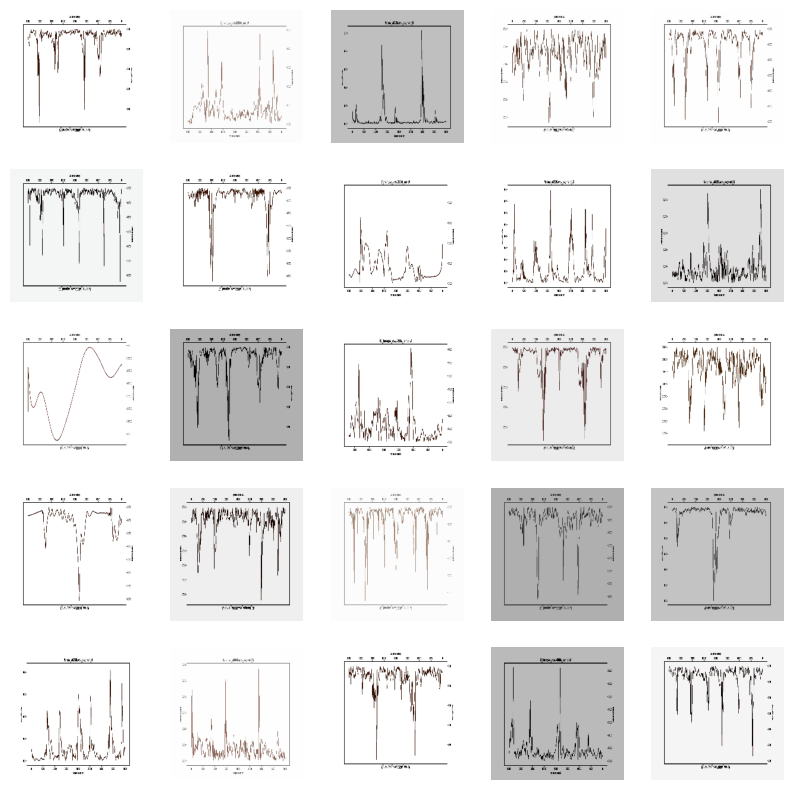

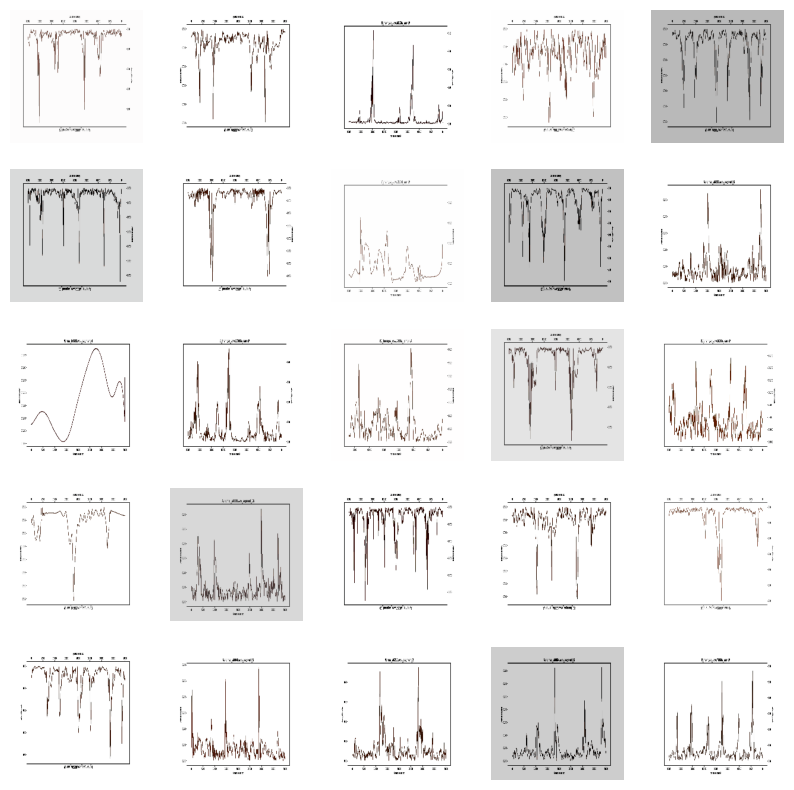

In [15]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

#### Defining the encoder and the predictor

We use an implementation of ResNet20 that is specifically configured for the CIFAR10 dataset. The code is taken from the keras-idiomatic-programmer repository. The hyperparameters of these architectures have been referred from Section 3 and Appendix A of the original paper.

In [15]:
!curl -O https://git.io/JYx2x -O resnet_cifar10_v2.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
curl: Remote file name has no length!
curl: (23) Failed writing received data to disk/application


In [16]:
from urllib.request import urlretrieve

urlretrieve("https://git.io/JYx2x", "resnet_cifar10_v2.py")

('resnet_cifar10_v2.py', <http.client.HTTPMessage at 0x1a425ff7fd0>)

In [16]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1
image_size_224 = 224

def get_encoder():
    
    # Input and backbone.
    inputs = layers.Input((image_size_224, image_size_224, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    outputs = layers.BatchNormalization()(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

#### Defining the pre-training loop
One of the main reasons behind training networks with these kinds of approaches is to utilize the learned representations for downstream tasks like classification. This is why this particular training phase is also referred to as pre-training.

We start by defining the loss function.

In [17]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

We then define our training loop by overriding the train_step() function of the keras.Model class.

In [18]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


#### Pre-training our networks
* In the interest of this example, we will train the model for only 5 epochs. In reality, this should at least be 100 epochs.

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
simsiam.save("simsiam")

### MobileNet

Epoch 1/50
225/225 [==============================] - 534s 2s/step - loss: -0.8802
Epoch 2/50
225/225 [==============================] - 525s 2s/step - loss: -0.9560
Epoch 3/50
225/225 [==============================] - 518s 2s/step - loss: -0.9616
Epoch 4/50
225/225 [==============================] - 518s 2s/step - loss: -0.9646
Epoch 5/50
225/225 [==============================] - 528s 2s/step - loss: -0.9664
Epoch 6/50
225/225 [==============================] - 517s 2s/step - loss: -0.9676
Epoch 7/50
225/225 [==============================] - 518s 2s/step - loss: -0.9684
Epoch 8/50
225/225 [==============================] - 518s 2s/step - loss: -0.9688
Epoch 9/50
225/225 [==============================] - 519s 2s/step - loss: -0.9690
Epoch 10/50
225/225 [==============================] - 518s 2s/step - loss: -0.9692
Epoch 11/50
225/225 [==============================] - 518s 2s/step - loss: -0.9696
Epoch 12/50
225/225 [==============================] - 530s 2s/step - loss: -0.9703
E

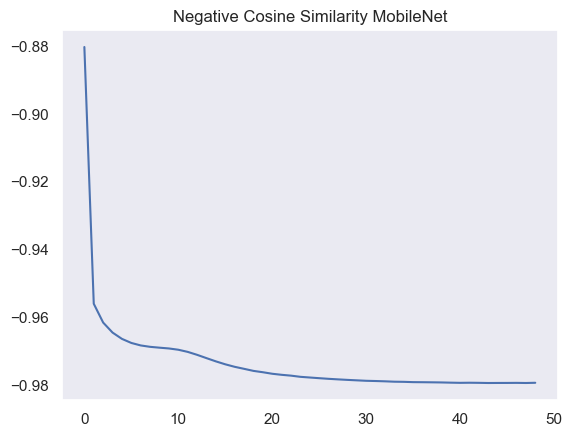

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import MobileNet

PROJECT_DIM = 2048  # Projection dimension
LATENT_DIM = 512   # Latent dimension
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
image_size_224 = 224
EPOCHS = 50
BATCH_SIZE = 32

def get_encoder():
    # Load pre-trained VGG16 model without top (fully connected) layers
    base_encoder = MobileNet(include_top=False, weights='imagenet', input_shape=(image_size_224, image_size_224, 3))
    for layer in base_encoder.layers:
        layer.trainable = False  # Freeze the layers
    
    # Create a new model with custom top layers
    inputs = tf.keras.Input((image_size_224, image_size_224, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = base_encoder(x, training=False)  # Use base encoder without training
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection head
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))



class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03, decay_steps=steps)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

# Compile model and start training.
simsiam_MobileNet = SimSiam(get_encoder(), get_predictor())
simsiam_MobileNet.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
simsiam_MobileNet_history = simsiam_MobileNet.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

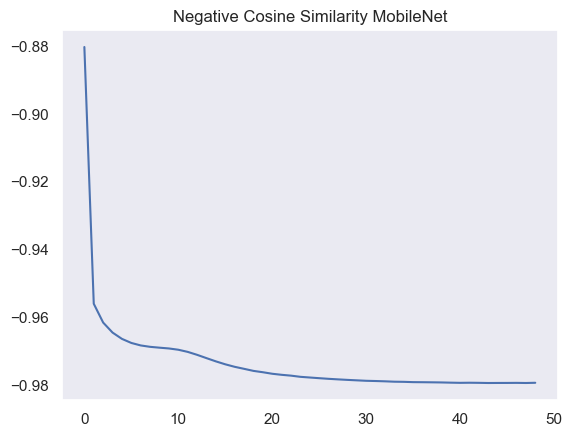

In [35]:
# Visualize the training progress of the model.
plt.plot(simsiam_MobileNet_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similarity MobileNet")
plt.show()

In [37]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone MobileNet.
MobileNet_backbone = keras.Model(
    simsiam_MobileNet.encoder.input, simsiam_MobileNet.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
MobileNet_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = MobileNet_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
MobileNet_linear_model = keras.Model(inputs, outputs, name="MobileNet_linear_model")

# Compile model and start training.
MobileNet_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
MobileNet_history = MobileNet_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = MobileNet_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

KeyboardInterrupt: 

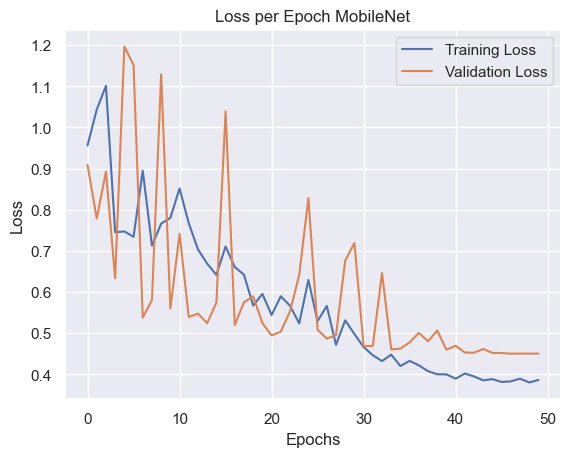

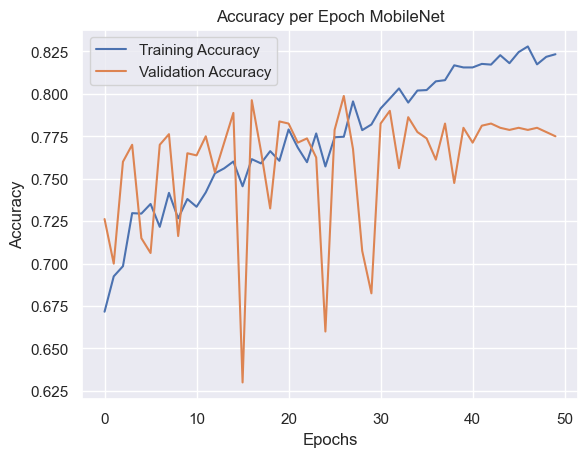

In [25]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(MobileNet_history.history['loss'], label='Training Loss')
plt.plot(MobileNet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch MobileNet')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(MobileNet_history.history['accuracy'], label='Training Accuracy')
plt.plot(MobileNet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch MobileNet')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = MobileNet_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

25/25 [==============================] - 27s 1s/step
Accuracy: 77.50%
Precision: 0.79
Recall: 0.73
F1-score: 0.76


25/25 [==============================] - 24s 960ms/step


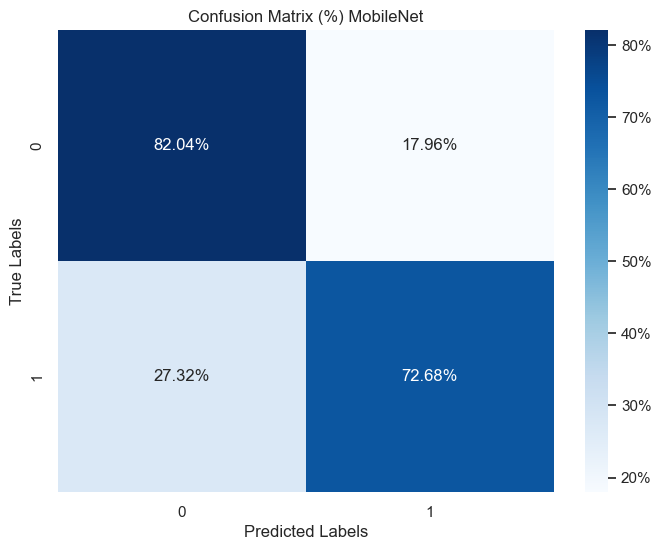

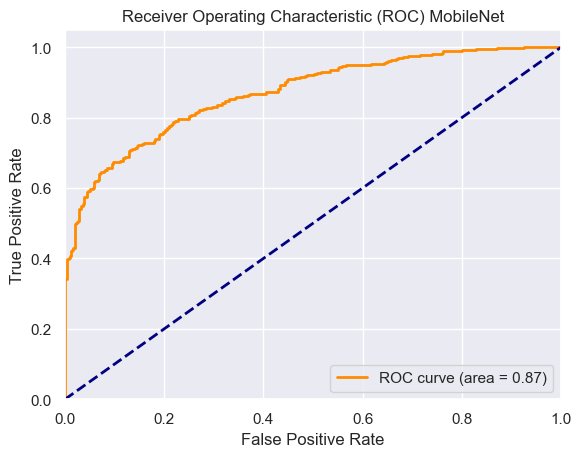

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       412
           1       0.79      0.73      0.76       388

    accuracy                           0.78       800
   macro avg       0.78      0.77      0.77       800
weighted avg       0.78      0.78      0.77       800



In [27]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = MobileNet_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%) MobileNet')
plt.savefig('MobileNet_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) MobileNet')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)


#### Mobilenet 1% labeled

In [106]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_1_percent, y_train_1_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone MobileNet.
MobileNet_backbone = keras.Model(
    simsiam_MobileNet.encoder.input, simsiam_MobileNet.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
MobileNet_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = MobileNet_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
MobileNet_linear_model = keras.Model(inputs, outputs, name="MobileNet_linear_model")

# Compile model and start training.
MobileNet_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
MobileNet_history = MobileNet_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = MobileNet_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
2/2 [==============================] - 29s 23s/step - loss: 0.7971 - accuracy: 0.5185 - val_loss: 0.6645 - val_accuracy: 0.6150
Epoch 2/50
2/2 [==============================] - 22s 21s/step - loss: 0.6430 - accuracy: 0.6852 - val_loss: 0.9117 - val_accuracy: 0.5100
Epoch 3/50
2/2 [==============================] - 24s 22s/step - loss: 0.7509 - accuracy: 0.5556 - val_loss: 0.7235 - val_accuracy: 0.6083
Epoch 4/50
2/2 [==============================] - 23s 22s/step - loss: 0.6086 - accuracy: 0.6667 - val_loss: 0.9512 - val_accuracy: 0.5617
Epoch 5/50
2/2 [==============================] - 22s 21s/step - loss: 0.6443 - accuracy: 0.7593 - val_loss: 0.8961 - val_accuracy: 0.6583
Epoch 6/50
2/2 [==============================] - 22s 20s/step - loss: 0.5427 - accuracy: 0.7222 - val_loss: 0.8326 - val_accuracy: 0.6517
Epoch 7/50
2/2 [==============================] - 22s 21s/step - loss: 0.5938 - accuracy: 0.7037 - val_loss: 0.8702 - val_accuracy: 0.6550
Epoch 8/50
2/2 [===========

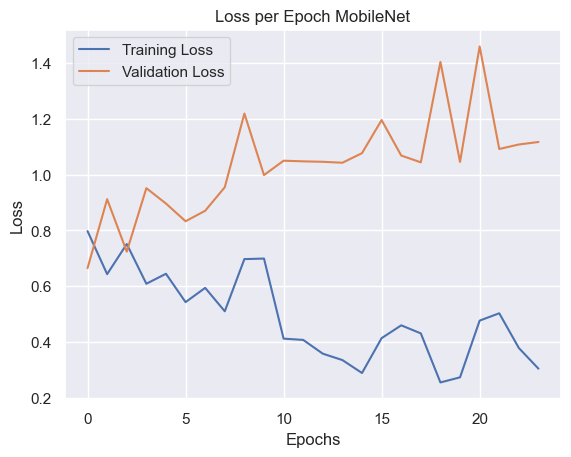

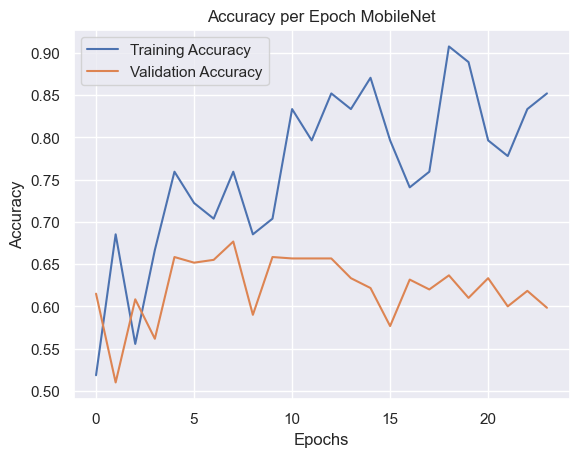

In [107]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(MobileNet_history.history['loss'], label='Training Loss')
plt.plot(MobileNet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch MobileNet')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(MobileNet_history.history['accuracy'], label='Training Accuracy')
plt.plot(MobileNet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch MobileNet')
plt.legend()
plt.show()

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = MobileNet_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

19/19 [==============================] - 29s 1s/step
Accuracy: 63.67%
Precision: 0.76
Recall: 0.36
F1-score: 0.48


19/19 [==============================] - 25s 1s/step


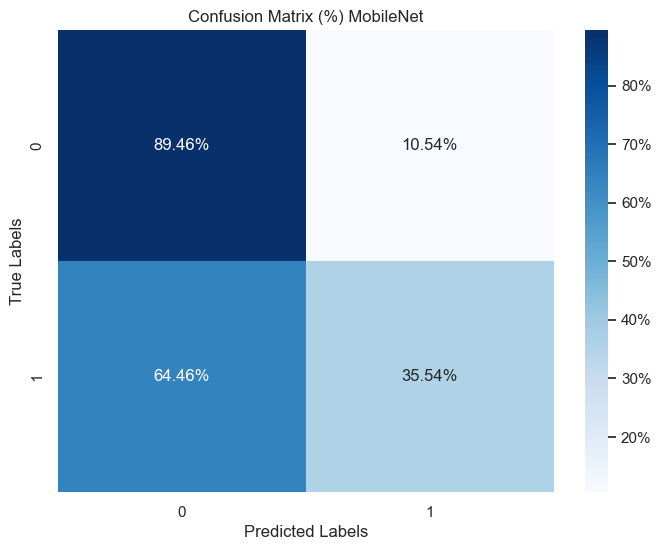

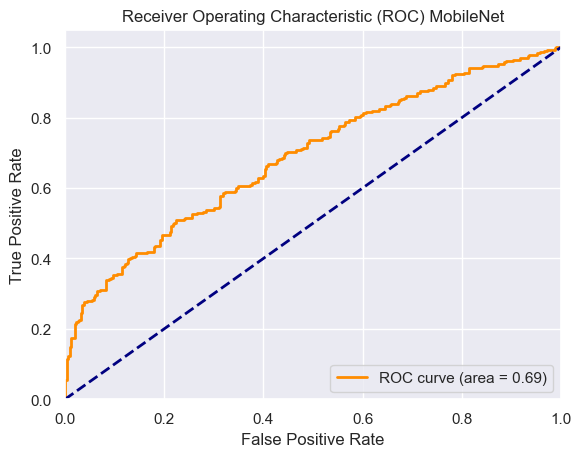

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.89      0.72       313
           1       0.76      0.36      0.48       287

    accuracy                           0.64       600
   macro avg       0.68      0.62      0.60       600
weighted avg       0.68      0.64      0.61       600



In [109]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = MobileNet_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%) MobileNet')
plt.savefig('MobileNet_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) MobileNet')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)


#### 10% labeled

In [110]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_10_percent, y_train_10_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone MobileNet.
MobileNet_backbone = keras.Model(
    simsiam_MobileNet.encoder.input, simsiam_MobileNet.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
MobileNet_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = MobileNet_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
MobileNet_linear_model = keras.Model(inputs, outputs, name="MobileNet_linear_model")

# Compile model and start training.
MobileNet_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
MobileNet_history = MobileNet_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = MobileNet_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
17/17 [==============================] - 46s 2s/step - loss: 0.6957 - accuracy: 0.6185 - val_loss: 1.1382 - val_accuracy: 0.5083
Epoch 2/50
17/17 [==============================] - 38s 2s/step - loss: 0.9949 - accuracy: 0.5926 - val_loss: 0.6701 - val_accuracy: 0.6933
Epoch 3/50
17/17 [==============================] - 39s 2s/step - loss: 1.1842 - accuracy: 0.6574 - val_loss: 0.6576 - val_accuracy: 0.7033
Epoch 4/50
17/17 [==============================] - 39s 2s/step - loss: 0.8492 - accuracy: 0.6648 - val_loss: 3.0891 - val_accuracy: 0.4783
Epoch 5/50
17/17 [==============================] - 40s 2s/step - loss: 1.2575 - accuracy: 0.6481 - val_loss: 1.7232 - val_accuracy: 0.6567
Epoch 6/50
19/19 [==============================] - 21s 1s/step - loss: 1.1382 - accuracy: 0.5083
Test accuracy: 50.83%


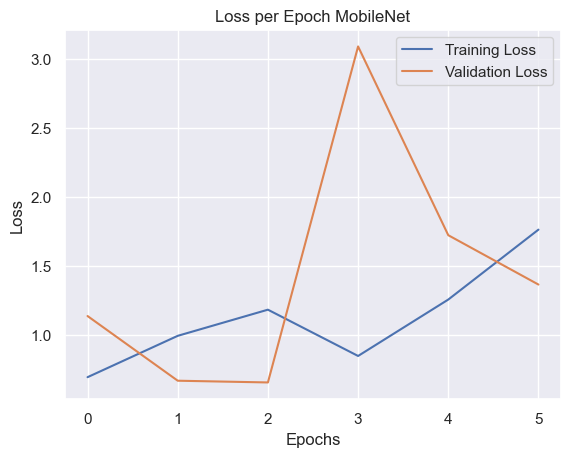

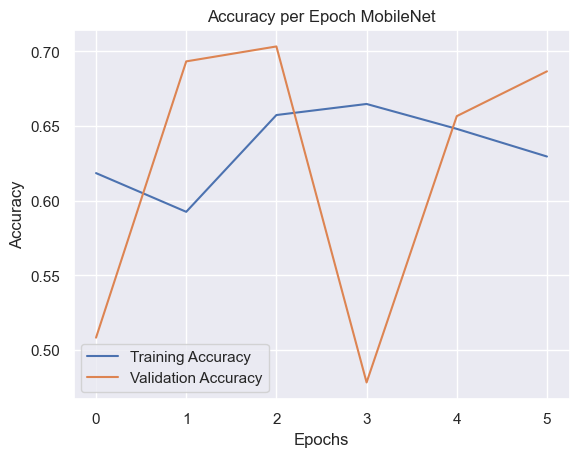

In [111]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(MobileNet_history.history['loss'], label='Training Loss')
plt.plot(MobileNet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch MobileNet')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(MobileNet_history.history['accuracy'], label='Training Accuracy')
plt.plot(MobileNet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch MobileNet')
plt.legend()
plt.show()

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = MobileNet_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

19/19 [==============================] - 26s 1s/step
Accuracy: 50.83%
Precision: 0.49
Recall: 0.99
F1-score: 0.66


19/19 [==============================] - 23s 1s/step


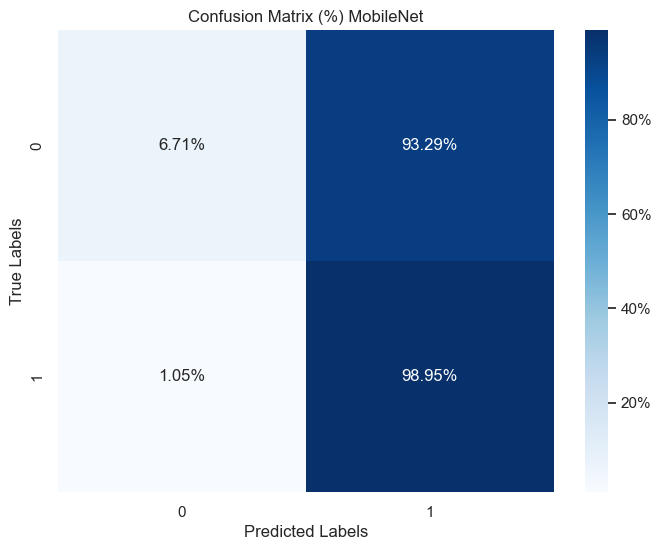

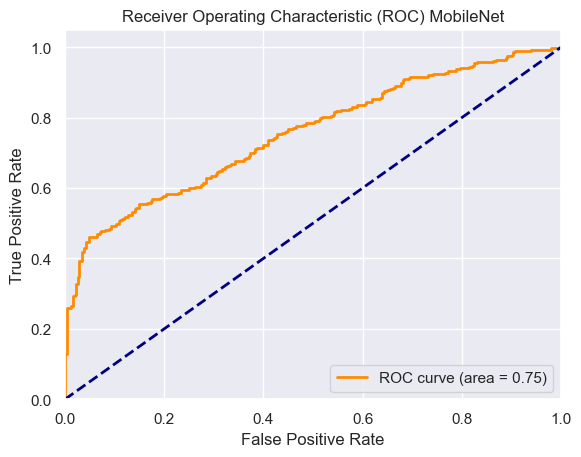

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.07      0.12       313
           1       0.49      0.99      0.66       287

    accuracy                           0.51       600
   macro avg       0.68      0.53      0.39       600
weighted avg       0.69      0.51      0.38       600



In [113]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = MobileNet_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%) MobileNet')
plt.savefig('MobileNet_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) MobileNet')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)


#### 20% labeled

In [114]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_20_percent, y_train_20_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone MobileNet.
MobileNet_backbone = keras.Model(
    simsiam_MobileNet.encoder.input, simsiam_MobileNet.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
MobileNet_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = MobileNet_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
MobileNet_linear_model = keras.Model(inputs, outputs, name="MobileNet_linear_model")

# Compile model and start training.
MobileNet_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
MobileNet_history = MobileNet_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = MobileNet_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
34/34 [==============================] - 65s 2s/step - loss: 0.9228 - accuracy: 0.6324 - val_loss: 1.1105 - val_accuracy: 0.5217
Epoch 2/50
34/34 [==============================] - 57s 2s/step - loss: 1.5262 - accuracy: 0.6028 - val_loss: 2.5900 - val_accuracy: 0.6550
Epoch 3/50
34/34 [==============================] - 58s 2s/step - loss: 1.8321 - accuracy: 0.6407 - val_loss: 3.8895 - val_accuracy: 0.4783
Epoch 4/50
34/34 [==============================] - 67s 2s/step - loss: 1.2084 - accuracy: 0.6861 - val_loss: 0.7761 - val_accuracy: 0.7067
Epoch 5/50
34/34 [==============================] - 60s 2s/step - loss: 0.7464 - accuracy: 0.6944 - val_loss: 1.3004 - val_accuracy: 0.6633
Epoch 6/50
34/34 [==============================] - 59s 2s/step - loss: 0.8972 - accuracy: 0.6741 - val_loss: 0.6310 - val_accuracy: 0.6933
Epoch 7/50
34/34 [==============================] - 61s 2s/step - loss: 0.7542 - accuracy: 0.6824 - val_loss: 1.1998 - val_accuracy: 0.6783
Epoch 8/50
34/34 [==

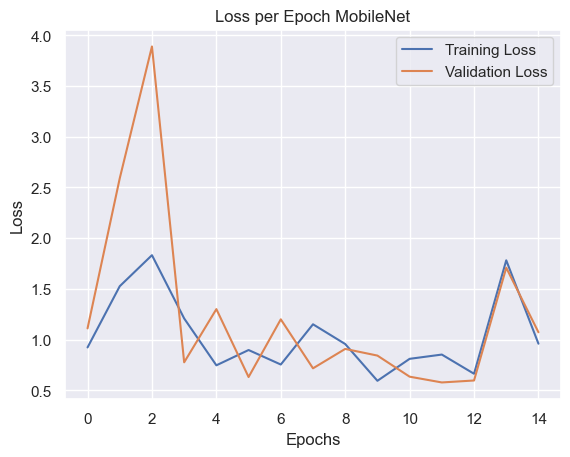

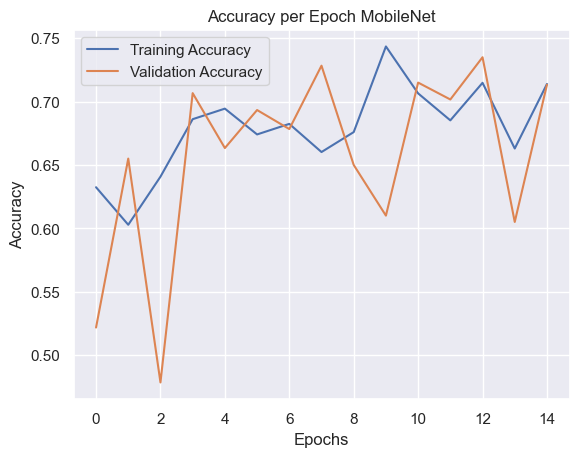

In [115]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(MobileNet_history.history['loss'], label='Training Loss')
plt.plot(MobileNet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch MobileNet')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(MobileNet_history.history['accuracy'], label='Training Accuracy')
plt.plot(MobileNet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch MobileNet')
plt.legend()
plt.show()

In [116]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = MobileNet_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

19/19 [==============================] - 24s 1s/step
Accuracy: 61.00%
Precision: 0.56
Recall: 0.91
F1-score: 0.69


19/19 [==============================] - 25s 1s/step


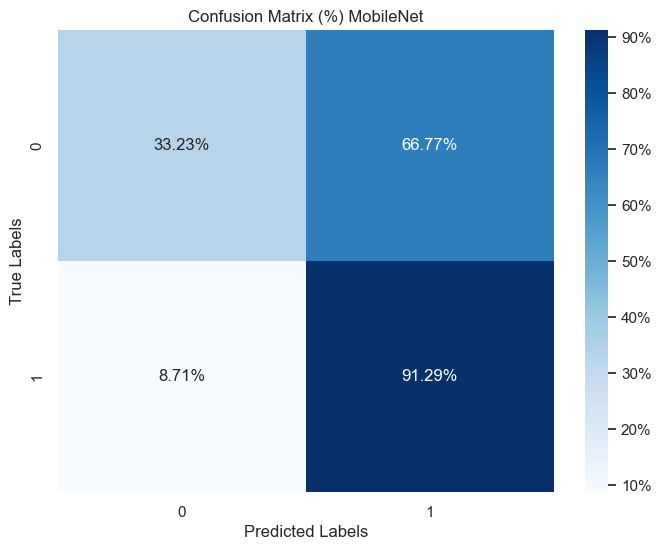

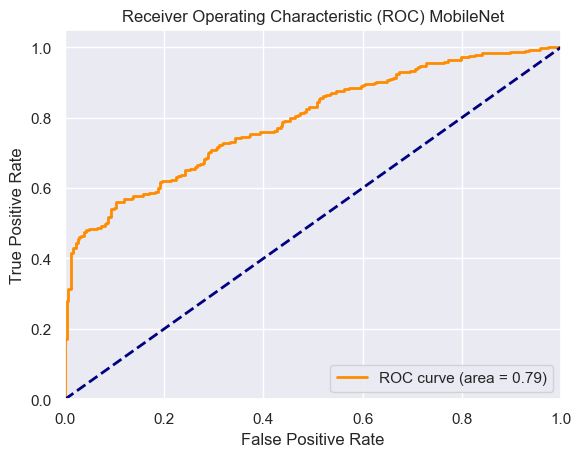

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.33      0.47       313
           1       0.56      0.91      0.69       287

    accuracy                           0.61       600
   macro avg       0.68      0.62      0.58       600
weighted avg       0.69      0.61      0.58       600



In [117]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = MobileNet_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%) MobileNet')
plt.savefig('MobileNet_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) MobileNet')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)


### Xception

Epoch 1/50
169/169 [==============================] - 1410s 8s/step - loss: -0.8401
Epoch 2/50
169/169 [==============================] - 1356s 8s/step - loss: -0.9454
Epoch 3/50
169/169 [==============================] - 1533s 9s/step - loss: -0.9527
Epoch 4/50
169/169 [==============================] - 1517s 9s/step - loss: -0.9567
Epoch 5/50
169/169 [==============================] - 1599s 9s/step - loss: -0.9593
Epoch 6/50
169/169 [==============================] - 1373s 8s/step - loss: -0.9605
Epoch 7/50
169/169 [==============================] - 1361s 8s/step - loss: -0.9615
Epoch 8/50
169/169 [==============================] - 1348s 8s/step - loss: -0.9619
Epoch 9/50
169/169 [==============================] - 1360s 8s/step - loss: -0.9623
Epoch 10/50
169/169 [==============================] - 1363s 8s/step - loss: -0.9625
Epoch 11/50
169/169 [==============================] - 1349s 8s/step - loss: -0.9631
Epoch 12/50
169/169 [==============================] - 1358s 8s/step - los

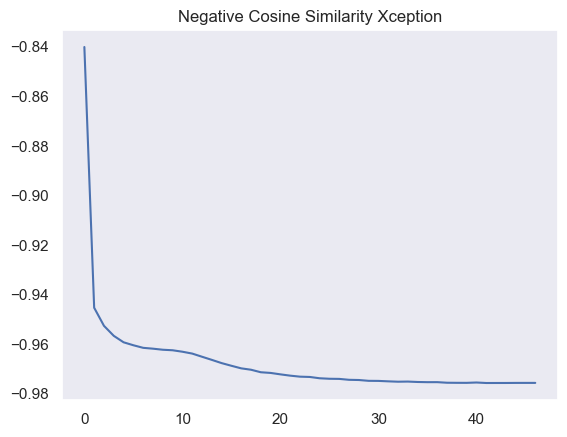

In [118]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import Xception

PROJECT_DIM = 2048  # Projection dimension
LATENT_DIM = 512   # Latent dimension
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
image_size_224 = 224
EPOCHS = 50
BATCH_SIZE = 32

def get_encoder():
    # Load pre-trained Xception model without top (fully connected) layers
    base_encoder = Xception(include_top=False, weights='imagenet', input_shape=(image_size_224, image_size_224, 3))
    for layer in base_encoder.layers:
        layer.trainable = False  # Freeze the layers
    
    # Create a new model with custom top layers
    inputs = tf.keras.Input((image_size_224, image_size_224, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = base_encoder(x, training=False)  # Use base encoder without training
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection head
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))



class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03, decay_steps=steps)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

# Compile model and start training.
simsiam_Xception = SimSiam(get_encoder(), get_predictor())
simsiam_Xception.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
simsiam_Xception_history = simsiam_Xception.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(simsiam_Xception_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similarity Xception")
plt.show()

In [119]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone MobileNet.
Xception_backbone = keras.Model(
    simsiam_Xception.encoder.input, simsiam_Xception.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
Xception_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = Xception_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
Xception_linear_model = keras.Model(inputs, outputs, name="Xception_linear_model")

# Compile model and start training.
Xception_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
Xception_history = Xception_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = Xception_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
169/169 [==============================] - 943s 5s/step - loss: 0.6466 - accuracy: 0.6598 - val_loss: 0.6314 - val_accuracy: 0.7000
Epoch 2/50
169/169 [==============================] - 905s 5s/step - loss: 0.6003 - accuracy: 0.6941 - val_loss: 0.5642 - val_accuracy: 0.6800
Epoch 3/50
169/169 [==============================] - 911s 5s/step - loss: 0.6084 - accuracy: 0.6874 - val_loss: 0.5181 - val_accuracy: 0.7417
Epoch 4/50
169/169 [==============================] - 906s 5s/step - loss: 0.5999 - accuracy: 0.6935 - val_loss: 0.5146 - val_accuracy: 0.7400
Epoch 5/50
169/169 [==============================] - 905s 5s/step - loss: 0.5662 - accuracy: 0.7109 - val_loss: 0.5092 - val_accuracy: 0.7350
Epoch 6/50
169/169 [==============================] - 906s 5s/step - loss: 0.5872 - accuracy: 0.7074 - val_loss: 0.5048 - val_accuracy: 0.7417
Epoch 7/50
169/169 [==============================] - 917s 5s/step - loss: 0.6719 - accuracy: 0.6978 - val_loss: 1.5867 - val_accuracy: 0.4800

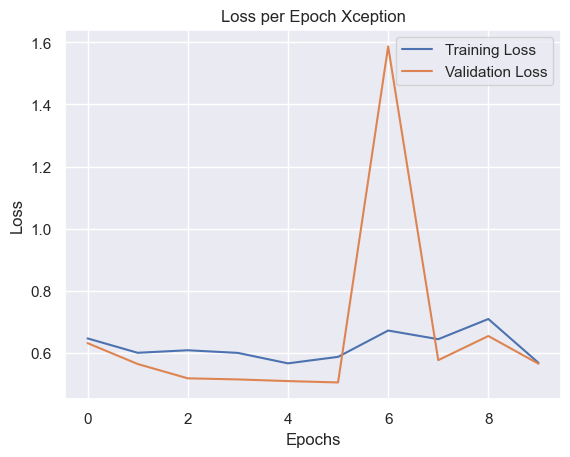

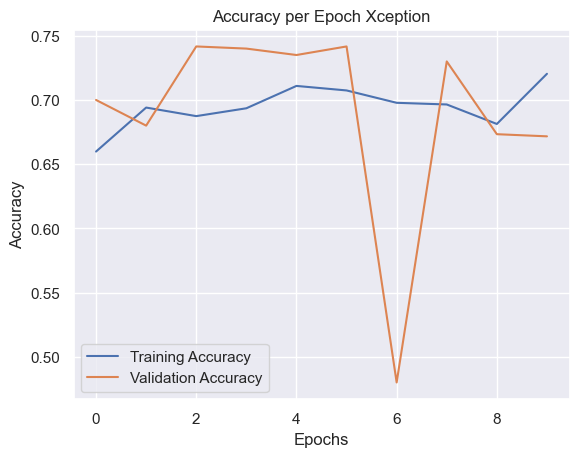

In [120]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(Xception_history.history['loss'], label='Training Loss')
plt.plot(Xception_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch Xception')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(Xception_history.history['accuracy'], label='Training Accuracy')
plt.plot(Xception_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch Xception')
plt.legend()
plt.show()

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = Xception_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

19/19 [==============================] - 93s 5s/step
Accuracy: 73.50%
Precision: 0.72
Recall: 0.72
F1-score: 0.72


19/19 [==============================] - 92s 5s/step


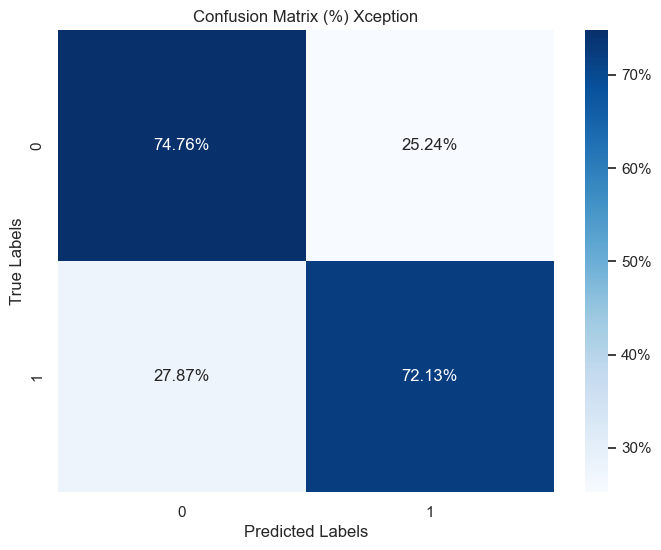

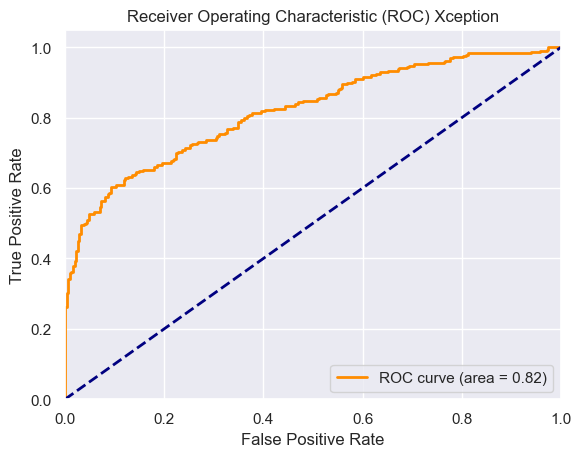

Xception Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       313
           1       0.72      0.72      0.72       287

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600



In [122]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = Xception_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%) Xception')
plt.savefig('Xception_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Xception')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Xception Classification Report:")
print(class_report)

#### 1% labeled

In [123]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_1_percent, y_train_1_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone MobileNet.
Xception_backbone = keras.Model(
    simsiam_Xception.encoder.input, simsiam_Xception.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
Xception_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = Xception_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
Xception_linear_model = keras.Model(inputs, outputs, name="Xception_linear_model")

# Compile model and start training.
Xception_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
Xception_history = Xception_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = Xception_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
2/2 [==============================] - 106s 91s/step - loss: 0.7400 - accuracy: 0.4259 - val_loss: 0.6808 - val_accuracy: 0.5800
Epoch 2/50
2/2 [==============================] - 93s 88s/step - loss: 0.6759 - accuracy: 0.5741 - val_loss: 0.6553 - val_accuracy: 0.6133
Epoch 3/50
2/2 [==============================] - 93s 88s/step - loss: 0.6596 - accuracy: 0.6296 - val_loss: 0.6601 - val_accuracy: 0.5717
Epoch 4/50
2/2 [==============================] - 93s 88s/step - loss: 0.6037 - accuracy: 0.6481 - val_loss: 0.6289 - val_accuracy: 0.6067
Epoch 5/50
2/2 [==============================] - 93s 88s/step - loss: 0.5340 - accuracy: 0.7037 - val_loss: 0.6492 - val_accuracy: 0.6833
Epoch 6/50
2/2 [==============================] - 92s 89s/step - loss: 0.5416 - accuracy: 0.7037 - val_loss: 0.6699 - val_accuracy: 0.6150
Epoch 7/50
2/2 [==============================] - 94s 88s/step - loss: 0.5036 - accuracy: 0.6667 - val_loss: 0.6965 - val_accuracy: 0.6117
Epoch 8/50
2/2 [==========

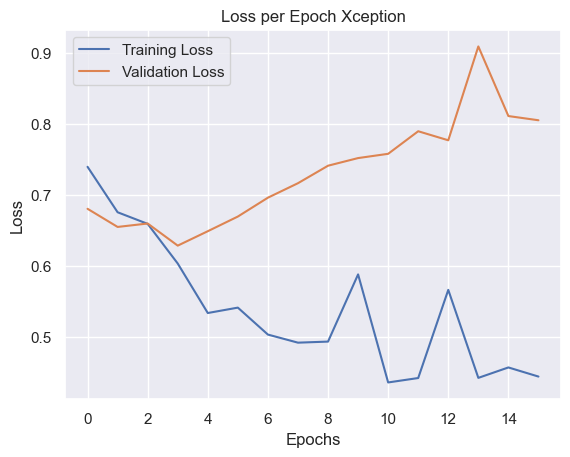

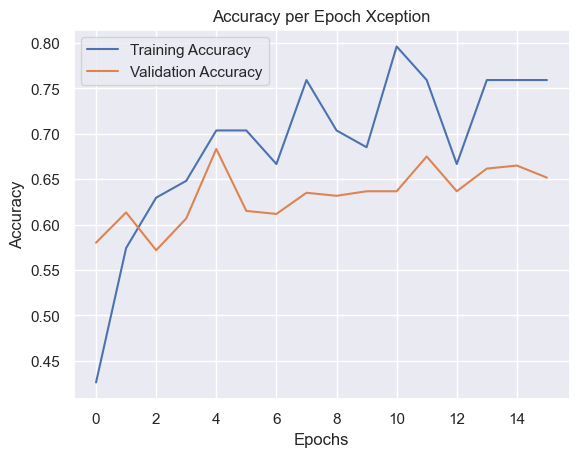

In [124]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(Xception_history.history['loss'], label='Training Loss')
plt.plot(Xception_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch Xception')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(Xception_history.history['accuracy'], label='Training Accuracy')
plt.plot(Xception_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch Xception')
plt.legend()
plt.show()

In [125]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = Xception_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

19/19 [==============================] - 92s 5s/step
Accuracy: 63.67%
Precision: 0.62
Recall: 0.63
F1-score: 0.63


19/19 [==============================] - 110s 6s/step


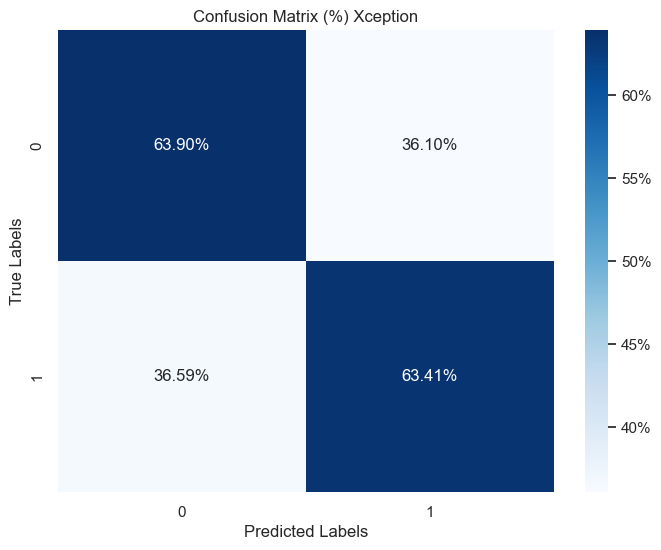

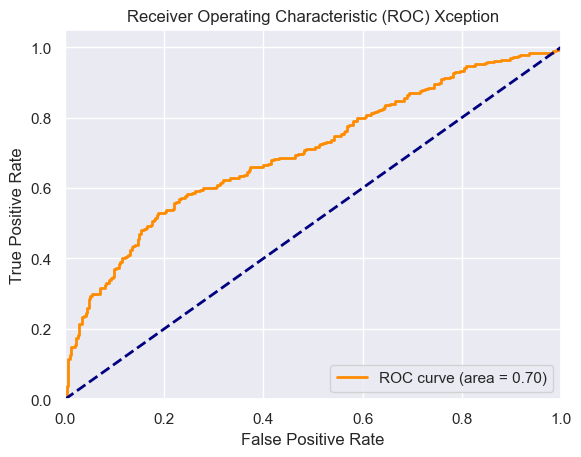

Xception Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       313
           1       0.62      0.63      0.63       287

    accuracy                           0.64       600
   macro avg       0.64      0.64      0.64       600
weighted avg       0.64      0.64      0.64       600



In [126]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = Xception_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%) Xception')
plt.savefig('Xception_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Xception')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Xception Classification Report:")
print(class_report)

#### 10% labeled

In [127]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_10_percent, y_train_10_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone MobileNet.
Xception_backbone = keras.Model(
    simsiam_Xception.encoder.input, simsiam_Xception.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
Xception_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = Xception_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
Xception_linear_model = keras.Model(inputs, outputs, name="Xception_linear_model")

# Compile model and start training.
Xception_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
Xception_history = Xception_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = Xception_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
17/17 [==============================] - 186s 10s/step - loss: 0.6558 - accuracy: 0.6074 - val_loss: 0.6164 - val_accuracy: 0.6950
Epoch 2/50
17/17 [==============================] - 163s 10s/step - loss: 0.6215 - accuracy: 0.6759 - val_loss: 1.0088 - val_accuracy: 0.4767
Epoch 3/50
17/17 [==============================] - 153s 9s/step - loss: 0.8343 - accuracy: 0.6296 - val_loss: 0.8931 - val_accuracy: 0.6817
Epoch 4/50
17/17 [==============================] - 155s 9s/step - loss: 1.0457 - accuracy: 0.6241 - val_loss: 1.5259 - val_accuracy: 0.6400
Epoch 5/50
17/17 [==============================] - 162s 10s/step - loss: 0.9765 - accuracy: 0.6278 - val_loss: 0.8761 - val_accuracy: 0.6883
Epoch 6/50
17/17 [==============================] - 152s 9s/step - loss: 0.6648 - accuracy: 0.6852 - val_loss: 0.9527 - val_accuracy: 0.5367
Epoch 7/50
19/19 [==============================] - 82s 4s/step - loss: 1.0088 - accuracy: 0.4767
Test accuracy: 47.67%


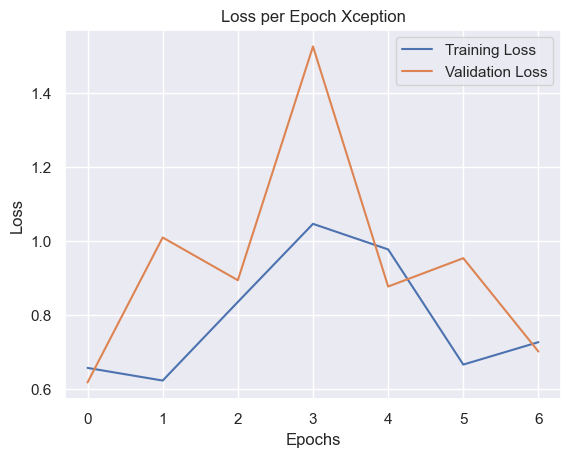

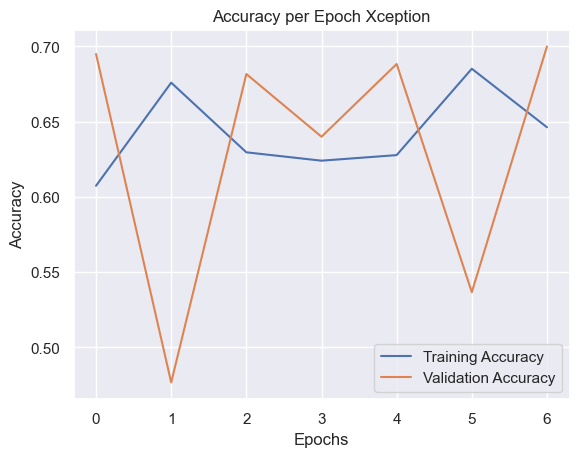

In [128]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(Xception_history.history['loss'], label='Training Loss')
plt.plot(Xception_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch Xception')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(Xception_history.history['accuracy'], label='Training Accuracy')
plt.plot(Xception_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch Xception')
plt.legend()
plt.show()

In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = Xception_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

19/19 [==============================] - 88s 5s/step
Accuracy: 47.67%
Precision: 0.48
Recall: 0.99
F1-score: 0.64


19/19 [==============================] - 94s 5s/step


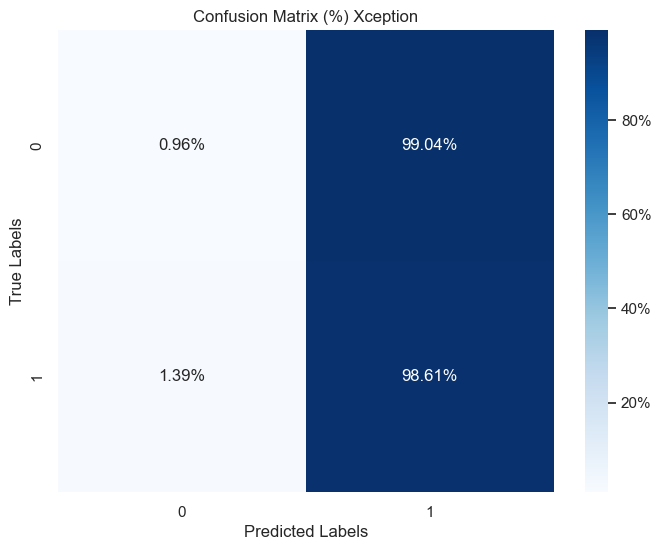

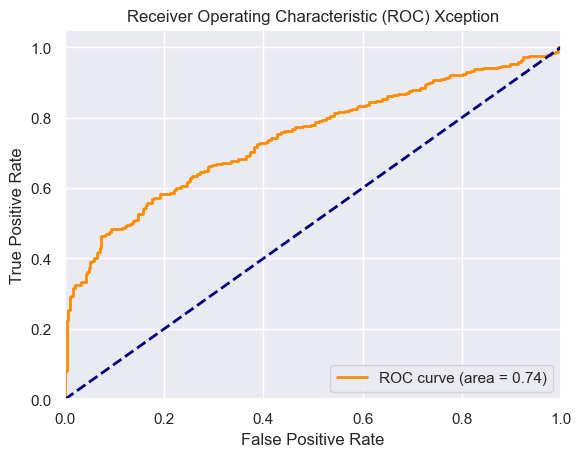

Xception Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.01      0.02       313
           1       0.48      0.99      0.64       287

    accuracy                           0.48       600
   macro avg       0.45      0.50      0.33       600
weighted avg       0.45      0.48      0.32       600



In [130]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = Xception_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%) Xception')
plt.savefig('Xception_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Xception')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Xception Classification Report:")
print(class_report)

#### 20% labeled

In [131]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_20_percent, y_train_20_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone MobileNet.
Xception_backbone = keras.Model(
    simsiam_Xception.encoder.input, simsiam_Xception.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
Xception_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = Xception_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
Xception_linear_model = keras.Model(inputs, outputs, name="Xception_linear_model")

# Compile model and start training.
Xception_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
Xception_history = Xception_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = Xception_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
34/34 [==============================] - 265s 8s/step - loss: 0.6840 - accuracy: 0.6250 - val_loss: 0.7796 - val_accuracy: 0.6667
Epoch 2/50
34/34 [==============================] - 255s 8s/step - loss: 0.7231 - accuracy: 0.6481 - val_loss: 0.6144 - val_accuracy: 0.6950
Epoch 3/50
34/34 [==============================] - 254s 8s/step - loss: 0.6960 - accuracy: 0.6620 - val_loss: 0.5881 - val_accuracy: 0.7117
Epoch 4/50
34/34 [==============================] - 249s 7s/step - loss: 0.7509 - accuracy: 0.6620 - val_loss: 0.9925 - val_accuracy: 0.5100
Epoch 5/50
34/34 [==============================] - 266s 8s/step - loss: 0.6586 - accuracy: 0.6750 - val_loss: 0.6485 - val_accuracy: 0.6917
Epoch 6/50
34/34 [==============================] - 257s 8s/step - loss: 0.6020 - accuracy: 0.6722 - val_loss: 0.5656 - val_accuracy: 0.7233
Epoch 7/50
34/34 [==============================] - 255s 8s/step - loss: 0.6080 - accuracy: 0.6907 - val_loss: 0.9997 - val_accuracy: 0.4983
Epoch 8/50
34

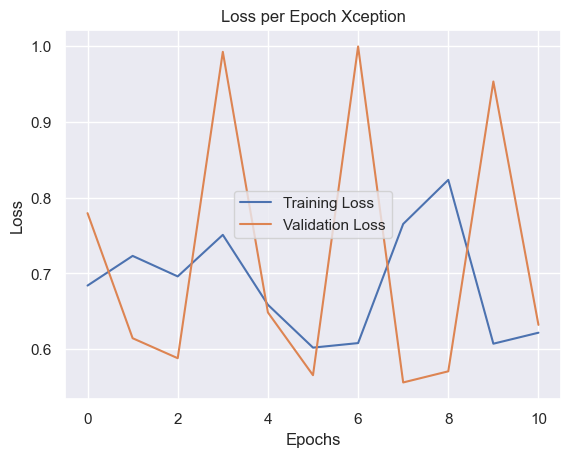

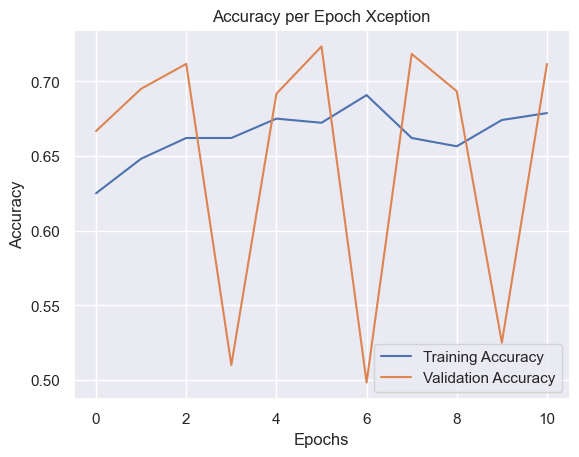

In [132]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(Xception_history.history['loss'], label='Training Loss')
plt.plot(Xception_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch Xception')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(Xception_history.history['accuracy'], label='Training Accuracy')
plt.plot(Xception_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch Xception')
plt.legend()
plt.show()

In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = Xception_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

19/19 [==============================] - 103s 5s/step
Accuracy: 72.33%
Precision: 0.76
Recall: 0.61
F1-score: 0.68


19/19 [==============================] - 99s 5s/step


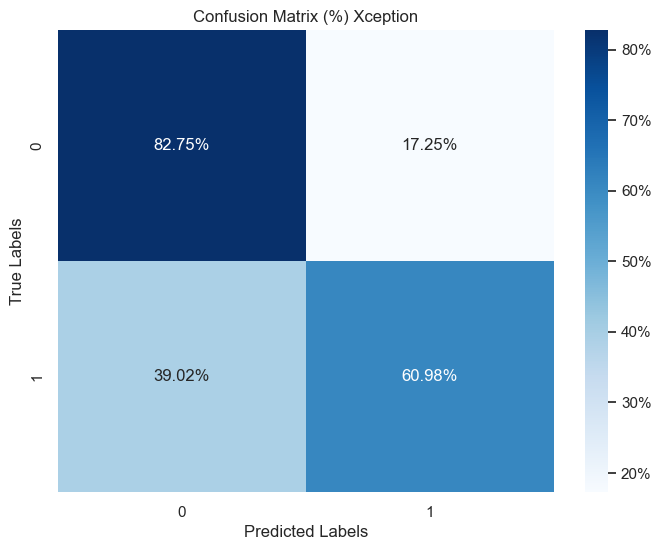

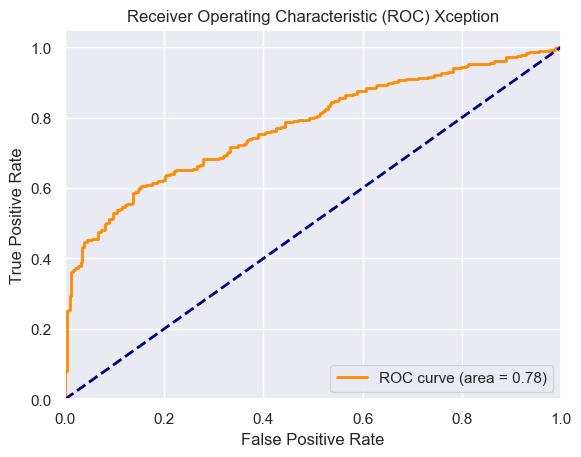

Xception Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       313
           1       0.76      0.61      0.68       287

    accuracy                           0.72       600
   macro avg       0.73      0.72      0.72       600
weighted avg       0.73      0.72      0.72       600



In [134]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = Xception_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%) Xception')
plt.savefig('Xception_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Xception')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Xception Classification Report:")
print(class_report)

### VGG 16

Epoch 1/50
37/37 [==============================] - 776s 21s/step - loss: -0.6588
Epoch 2/50
37/37 [==============================] - 786s 21s/step - loss: -0.9817
Epoch 3/50
37/37 [==============================] - 810s 22s/step - loss: -0.9925
Epoch 4/50
37/37 [==============================] - 770s 21s/step - loss: -0.9935
Epoch 5/50
37/37 [==============================] - 765s 21s/step - loss: -0.9940
Epoch 6/50
37/37 [==============================] - 767s 21s/step - loss: -0.9943
Epoch 7/50
37/37 [==============================] - 763s 21s/step - loss: -0.9946
Epoch 8/50
37/37 [==============================] - 775s 21s/step - loss: -0.9947
Epoch 9/50
37/37 [==============================] - 773s 21s/step - loss: -0.9949
Epoch 10/50
37/37 [==============================] - 773s 21s/step - loss: -0.9950
Epoch 11/50
37/37 [==============================] - 728s 20s/step - loss: -0.9952
Epoch 12/50
37/37 [==============================] - 707s 19s/step - loss: -0.9953
Epoch 13/50
3

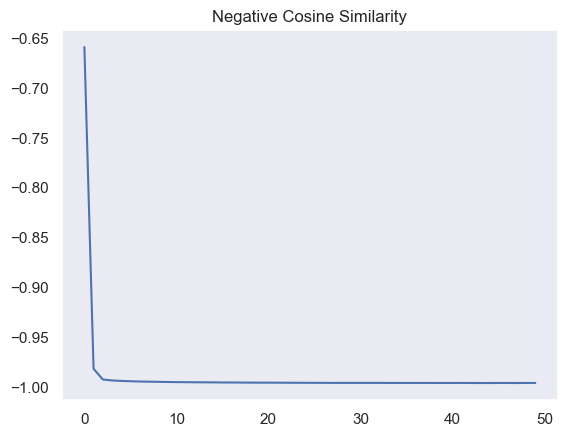

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import VGG16

PROJECT_DIM = 2048  # Projection dimension
LATENT_DIM = 512   # Latent dimension
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
image_size_224 = 224
EPOCHS = 50
BATCH_SIZE = 32

def get_encoder():
    # Load pre-trained VGG16 model without top (fully connected) layers
    base_encoder = VGG16(include_top=False, weights='imagenet', input_shape=(image_size_224, image_size_224, 3))
    for layer in base_encoder.layers:
        layer.trainable = False  # Freeze the layers
    
    # Create a new model with custom top layers
    inputs = tf.keras.Input((image_size_224, image_size_224, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = base_encoder(x, training=False)  # Use base encoder without training
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection head
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))



class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03, decay_steps=steps)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

# Compile model and start training.
simsiam_vgg16 = SimSiam(get_encoder(), get_predictor())
simsiam_vgg16.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
simsiam_vgg16_history = simsiam_vgg16.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(simsiam_vgg16_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similarity VGG16")
plt.show()


In [19]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone VGG19.
VGG16_backbone = keras.Model(
    simsiam_vgg16.encoder.input, simsiam_vgg16.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
VGG16_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = VGG16_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
VGG16_linear_model = keras.Model(inputs, outputs, name="VGG16_linear_model")

# Compile model and start training.
VGG16_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
VGG16_history = VGG16_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = VGG16_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
37/37 [==============================] - 441s 12s/step - loss: 0.8104 - accuracy: 0.5357 - val_loss: 0.7511 - val_accuracy: 0.5052
Epoch 2/50
37/37 [==============================] - 434s 12s/step - loss: 0.6749 - accuracy: 0.6148 - val_loss: 0.6070 - val_accuracy: 0.7113
Epoch 3/50
37/37 [==============================] - 441s 12s/step - loss: 0.7820 - accuracy: 0.5933 - val_loss: 0.6744 - val_accuracy: 0.5533
Epoch 4/50
37/37 [==============================] - 437s 12s/step - loss: 0.6014 - accuracy: 0.6776 - val_loss: 0.6679 - val_accuracy: 0.6426
Epoch 5/50
37/37 [==============================] - 434s 12s/step - loss: 0.5910 - accuracy: 0.6819 - val_loss: 0.6180 - val_accuracy: 0.6014
Epoch 6/50
37/37 [==============================] - 436s 12s/step - loss: 0.5816 - accuracy: 0.6887 - val_loss: 0.5520 - val_accuracy: 0.7526
Epoch 7/50
37/37 [==============================] - 438s 12s/step - loss: 0.5463 - accuracy: 0.7180 - val_loss: 0.6382 - val_accuracy: 0.6804
Epoch 

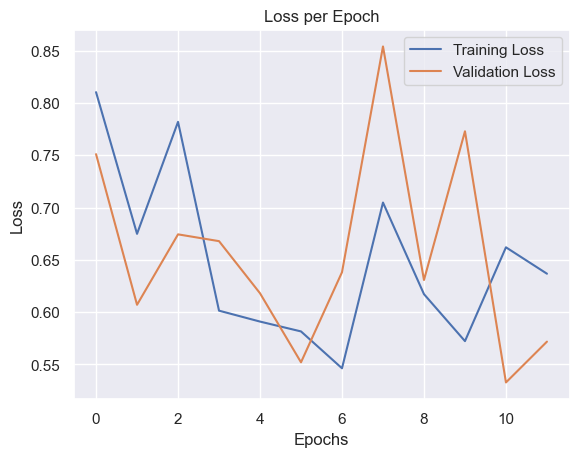

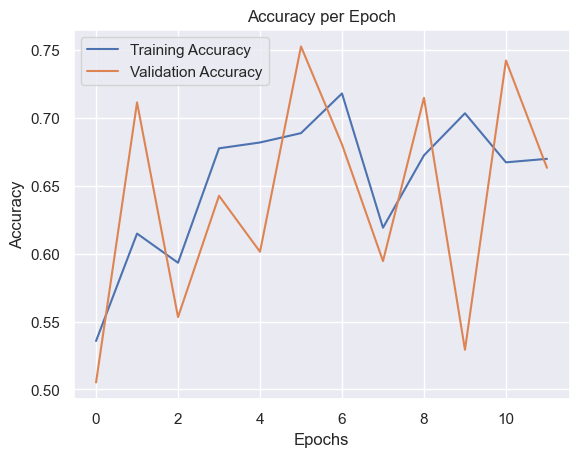

In [20]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(VGG16_history.history['loss'], label='Training Loss')
plt.plot(VGG16_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch VGG16')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(VGG16_history.history['accuracy'], label='Training Accuracy')
plt.plot(VGG16_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch VGG16')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = VGG16_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

10/10 [==============================] - 86s 8s/step
Accuracy: 68.04%
Precision: 0.63
Recall: 0.99
F1-score: 0.77


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = VGG16_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix VGG16')
plt.savefig('VGG16_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) VGG16')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)


10/10 [==============================] - 98s 10s/step
Confusion Matrix:
[[ 46  91]
 [  2 152]]


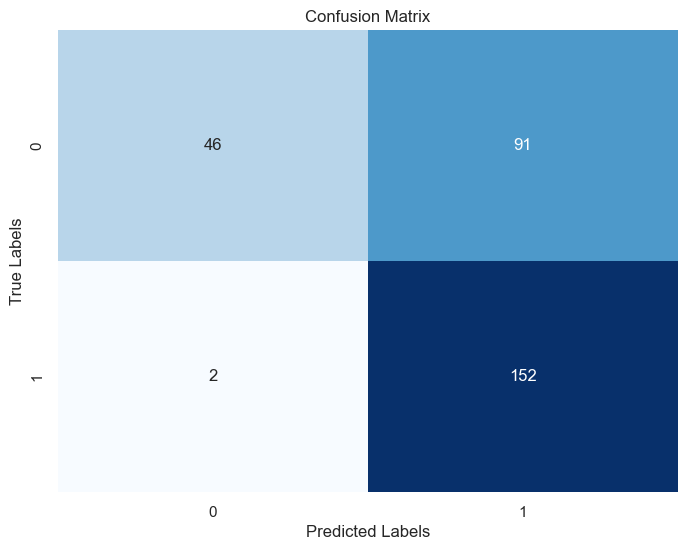

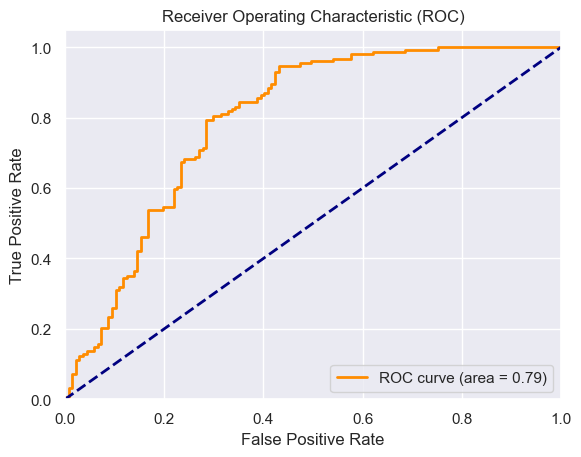

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.34      0.50       137
           1       0.63      0.99      0.77       154

    accuracy                           0.68       291
   macro avg       0.79      0.66      0.63       291
weighted avg       0.78      0.68      0.64       291



In [22]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns


# Predict probabilities for the test set
y_pred_proba = VGG16_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix VGG16')
plt.show()


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) VGG16')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)


### VGG19

Epoch 1/50
37/37 [==============================] - 909s 24s/step - loss: -0.6694
Epoch 2/50
37/37 [==============================] - 873s 24s/step - loss: -0.9806
Epoch 3/50
37/37 [==============================] - 885s 24s/step - loss: -0.9929
Epoch 4/50
37/37 [==============================] - 880s 24s/step - loss: -0.9939
Epoch 5/50
37/37 [==============================] - 877s 24s/step - loss: -0.9944
Epoch 6/50
37/37 [==============================] - 947s 26s/step - loss: -0.9947
Epoch 7/50
37/37 [==============================] - 967s 26s/step - loss: -0.9950
Epoch 8/50
37/37 [==============================] - 965s 26s/step - loss: -0.9952
Epoch 9/50
37/37 [==============================] - 965s 26s/step - loss: -0.9953
Epoch 10/50
37/37 [==============================] - 969s 26s/step - loss: -0.9955
Epoch 11/50
37/37 [==============================] - 959s 26s/step - loss: -0.9956
Epoch 12/50
37/37 [==============================] - 968s 26s/step - loss: -0.9957
Epoch 13/50
3

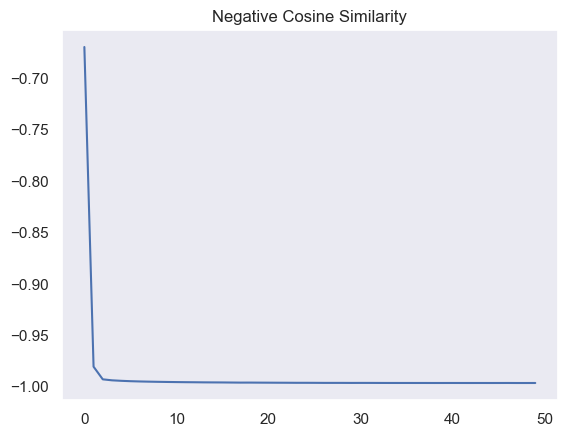

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import VGG19

PROJECT_DIM = 2048  # Projection dimension
LATENT_DIM = 512   # Latent dimension
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
image_size_224 = 224
EPOCHS = 50
BATCH_SIZE = 32

def get_encoder():
    # Load pre-trained VGG16 model without top (fully connected) layers
    base_encoder = VGG19(include_top=False, weights='imagenet', input_shape=(image_size_224, image_size_224, 3))
    for layer in base_encoder.layers:
        layer.trainable = False  # Freeze the layers
    
    # Create a new model with custom top layers
    inputs = tf.keras.Input((image_size_224, image_size_224, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = base_encoder(x, training=False)  # Use base encoder without training
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection head
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))



class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03, decay_steps=steps)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

# Compile model and start training.
simsiam_VGG19 = SimSiam(get_encoder(), get_predictor())
simsiam_VGG19.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
simsiam_VGG19_history = simsiam_VGG19.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(simsiam_VGG19_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similarity VGG19")
plt.show()


In [24]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone VGG19.
VGG19_backbone = keras.Model(
    simsiam_VGG19.encoder.input, simsiam_VGG19.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
VGG19_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = VGG19_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
VGG19_linear_model = keras.Model(inputs, outputs, name="VGG19_linear_model")

# Compile model and start training.
VGG19_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
VGG19_history = VGG19_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = VGG19_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
37/37 [==============================] - 607s 16s/step - loss: 0.7246 - accuracy: 0.5047 - val_loss: 0.6764 - val_accuracy: 0.5430
Epoch 2/50
37/37 [==============================] - 606s 16s/step - loss: 0.8207 - accuracy: 0.5254 - val_loss: 0.6241 - val_accuracy: 0.6495
Epoch 3/50
37/37 [==============================] - 602s 16s/step - loss: 0.7149 - accuracy: 0.5864 - val_loss: 0.6681 - val_accuracy: 0.5876
Epoch 4/50
37/37 [==============================] - 615s 17s/step - loss: 0.6392 - accuracy: 0.6363 - val_loss: 0.6094 - val_accuracy: 0.6667
Epoch 5/50
37/37 [==============================] - 605s 16s/step - loss: 0.7004 - accuracy: 0.6002 - val_loss: 0.8225 - val_accuracy: 0.5361
Epoch 6/50
37/37 [==============================] - 614s 17s/step - loss: 0.7540 - accuracy: 0.6002 - val_loss: 0.6315 - val_accuracy: 0.6151
Epoch 7/50
37/37 [==============================] - 606s 16s/step - loss: 0.5928 - accuracy: 0.6767 - val_loss: 0.5825 - val_accuracy: 0.7079
Epoch 

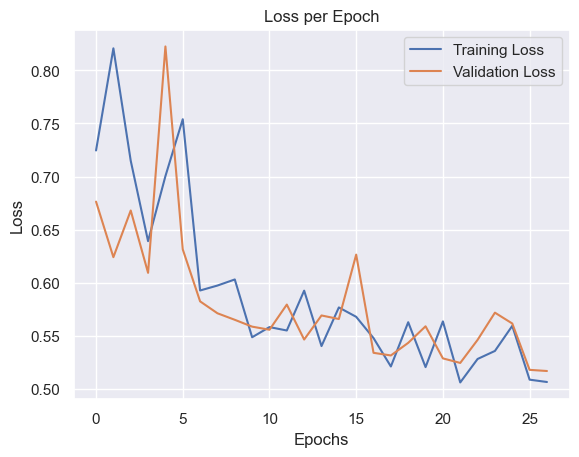

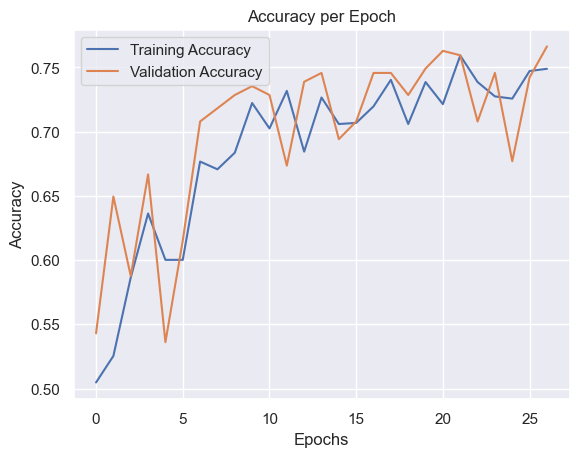

In [25]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(VGG19_history.history['loss'], label='Training Loss')
plt.plot(VGG19_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch VGG19')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(VGG19_history.history['accuracy'], label='Training Accuracy')
plt.plot(VGG19_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch VGG19')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = VGG19_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

10/10 [==============================] - 118s 12s/step
Accuracy: 75.95%
Precision: 0.75
Recall: 0.81
F1-score: 0.78


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = VGG19_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix VGG19')
plt.savefig('VGG16_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) VGG19')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

### ResNet50

Epoch 1/50
225/225 [==============================] - 1747s 8s/step - loss: -0.9303
Epoch 2/50
225/225 [==============================] - 1729s 8s/step - loss: -0.9912
Epoch 3/50
225/225 [==============================] - 1743s 8s/step - loss: -0.9923
Epoch 4/50
225/225 [==============================] - 1725s 8s/step - loss: -0.9928
Epoch 5/50
225/225 [==============================] - 1738s 8s/step - loss: -0.9933
Epoch 6/50
225/225 [==============================] - 1726s 8s/step - loss: -0.9936
Epoch 7/50
225/225 [==============================] - 1732s 8s/step - loss: -0.9938
Epoch 8/50
225/225 [==============================] - 1735s 8s/step - loss: -0.9940
Epoch 9/50
225/225 [==============================] - 1742s 8s/step - loss: -0.9942
Epoch 10/50
225/225 [==============================] - 1724s 8s/step - loss: -0.9943
Epoch 11/50
225/225 [==============================] - 13998s 62s/step - loss: -0.9945
Epoch 12/50
225/225 [==============================] - 1740s 8s/step - l

<function matplotlib.pyplot.show(close=None, block=None)>

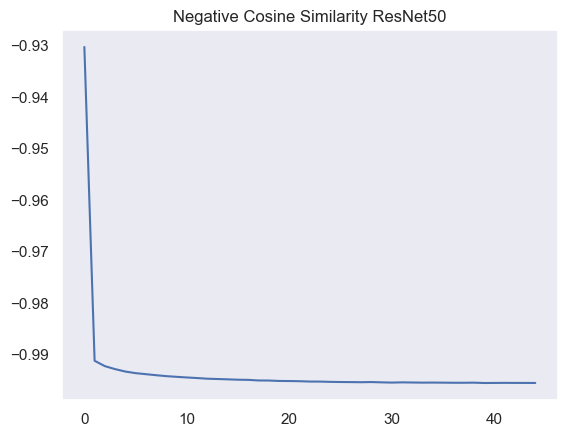

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import ResNet50

PROJECT_DIM = 2048  # Projection dimension
LATENT_DIM = 512   # Latent dimension
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
image_size_224 = 224
EPOCHS = 50
BATCH_SIZE = 32

def get_encoder():
    # Load pre-trained VGG16 model without top (fully connected) layers
    base_encoder = ResNet50(include_top=False, weights='imagenet', input_shape=(image_size_224, image_size_224, 3))
    for layer in base_encoder.layers:
        layer.trainable = False  # Freeze the layers
    
    # Create a new model with custom top layers
    inputs = tf.keras.Input((image_size_224, image_size_224, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = base_encoder(x, training=False)  # Use base encoder without training
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection head
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))



class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03, decay_steps=steps)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

# Compile model and start training.
simsiam_resnet50 = SimSiam(get_encoder(), get_predictor())
simsiam_resnet50.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
simsiam_resnet50_history = simsiam_resnet50.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

<function matplotlib.pyplot.show(close=None, block=None)>

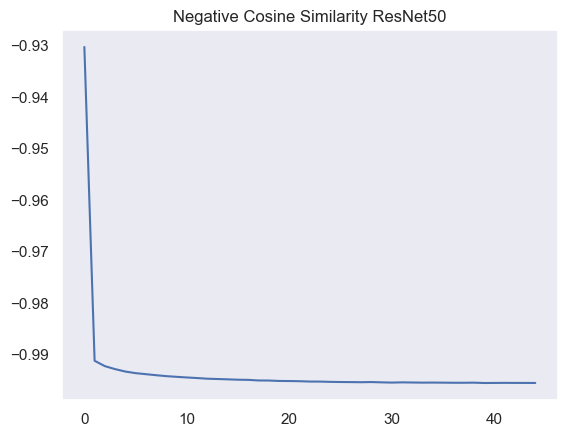

In [36]:
# Visualize the training progress of the model.
plt.plot(simsiam_resnet50_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similarity ResNet50")
plt.show

In [31]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone.
resnet50_backbone = keras.Model(
    simsiam_resnet50.encoder.input, simsiam_resnet50.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
resnet50_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = resnet50_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
resnet50_linear_model = keras.Model(inputs, outputs, name="resnet50_linear_model")

# Compile model and start training.
resnet50_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
resnet50_history = resnet50_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = resnet50_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
225/225 [==============================] - 6179s 28s/step - loss: 2.3211 - accuracy: 0.6133 - val_loss: 1.5352 - val_accuracy: 0.6750
Epoch 2/50
225/225 [==============================] - 996s 4s/step - loss: 1.8196 - accuracy: 0.6543 - val_loss: 1.9375 - val_accuracy: 0.6475
Epoch 3/50
225/225 [==============================] - 981s 4s/step - loss: 1.6940 - accuracy: 0.6543 - val_loss: 2.0524 - val_accuracy: 0.4888
Epoch 4/50
225/225 [==============================] - 1069s 5s/step - loss: 1.8201 - accuracy: 0.6488 - val_loss: 3.2696 - val_accuracy: 0.5987
Epoch 5/50
225/225 [==============================] - 1058s 5s/step - loss: 1.8471 - accuracy: 0.6517 - val_loss: 1.0360 - val_accuracy: 0.6313
Epoch 6/50
225/225 [==============================] - 1058s 5s/step - loss: 1.5518 - accuracy: 0.6606 - val_loss: 0.8785 - val_accuracy: 0.7450
Epoch 7/50
225/225 [==============================] - 1059s 5s/step - loss: 1.8681 - accuracy: 0.6451 - val_loss: 1.0143 - val_accuracy: 

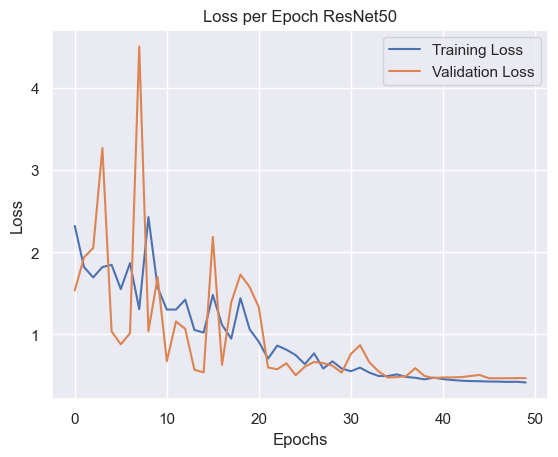

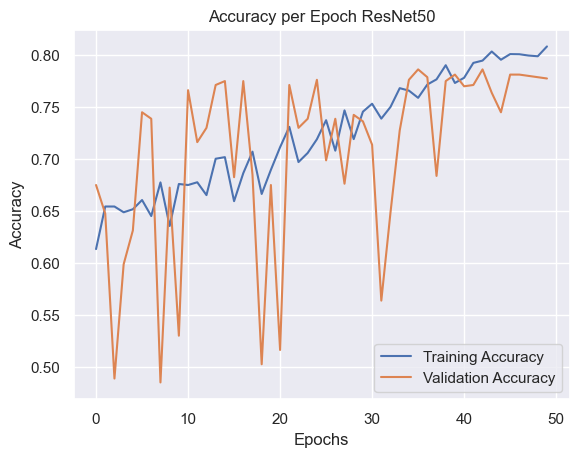

In [32]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(resnet50_history.history['loss'], label='Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch ResNet50')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch ResNet50')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = resnet50_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

25/25 [==============================] - 108s 4s/step
Accuracy: 77.75%
Precision: 0.79
Recall: 0.74
F1-score: 0.76


25/25 [==============================] - 103s 4s/step


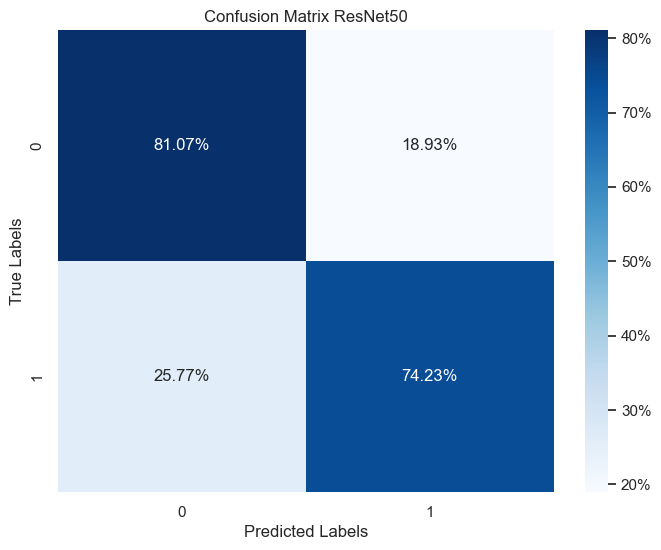

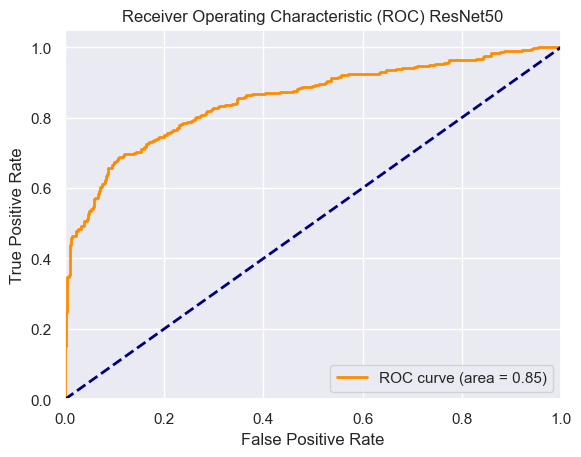

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       412
           1       0.79      0.74      0.76       388

    accuracy                           0.78       800
   macro avg       0.78      0.78      0.78       800
weighted avg       0.78      0.78      0.78       800



In [34]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = resnet50_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ResNet50')
plt.savefig('ResNet50_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ResNet50')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

#### 1%

In [22]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_1_percent, y_train_1_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone.
resnet50_backbone = keras.Model(
    simsiam_resnet50.encoder.input, simsiam_resnet50.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
resnet50_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = resnet50_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
resnet50_linear_model = keras.Model(inputs, outputs, name="resnet50_linear_model")

# Compile model and start training.
resnet50_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
resnet50_history = resnet50_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = resnet50_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
1/1 [==============================] - 75s 75s/step - loss: 1.0494 - accuracy: 0.5000 - val_loss: 3.1060 - val_accuracy: 0.5025
Epoch 2/50
1/1 [==============================] - 65s 65s/step - loss: 3.1711 - accuracy: 0.5000 - val_loss: 1.0355 - val_accuracy: 0.5025
Epoch 3/50
1/1 [==============================] - 60s 60s/step - loss: 1.1189 - accuracy: 0.5000 - val_loss: 5.6312 - val_accuracy: 0.4975
Epoch 4/50
1/1 [==============================] - 60s 60s/step - loss: 5.4140 - accuracy: 0.5000 - val_loss: 5.5605 - val_accuracy: 0.4975
Epoch 5/50
1/1 [==============================] - 51s 51s/step - loss: 5.3675 - accuracy: 0.5000 - val_loss: 0.8225 - val_accuracy: 0.5025
Epoch 6/50
1/1 [==============================] - 50s 50s/step - loss: 0.8681 - accuracy: 0.5000 - val_loss: 2.7591 - val_accuracy: 0.5025
Epoch 7/50
1/1 [==============================] - 47s 47s/step - loss: 2.8565 - accuracy: 0.5000 - val_loss: 1.2009 - val_accuracy: 0.4975
Epoch 8/50
1/1 [===========

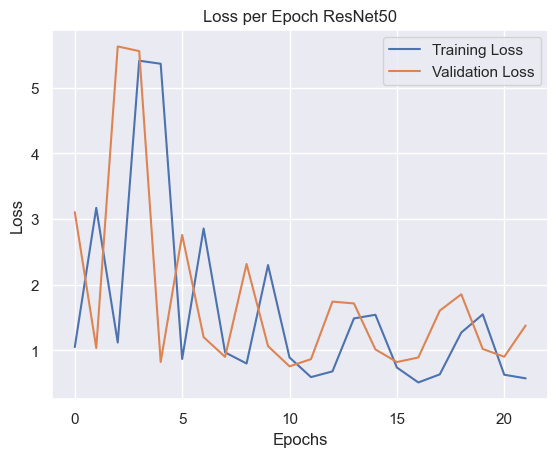

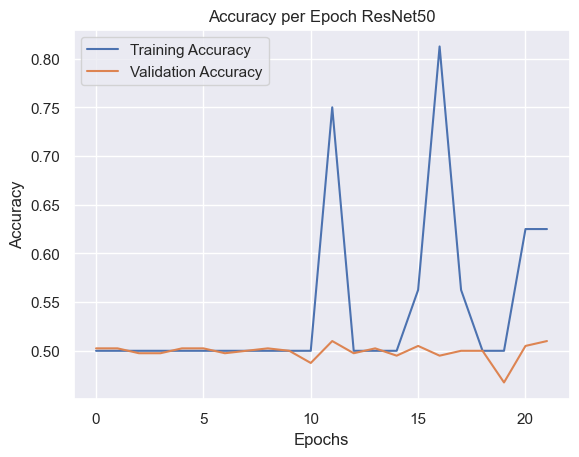

In [23]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(resnet50_history.history['loss'], label='Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch ResNet50')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch ResNet50')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = resnet50_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

13/13 [==============================] - 56s 4s/step
Accuracy: 49.50%
Precision: 0.48
Recall: 0.22
F1-score: 0.30


13/13 [==============================] - 55s 4s/step


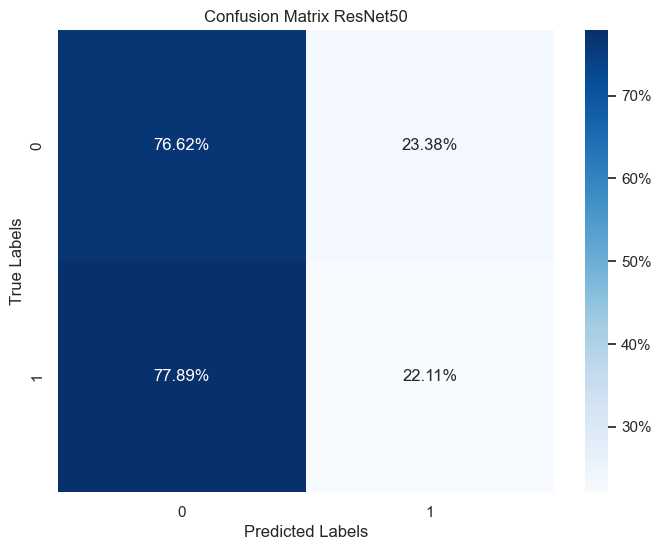

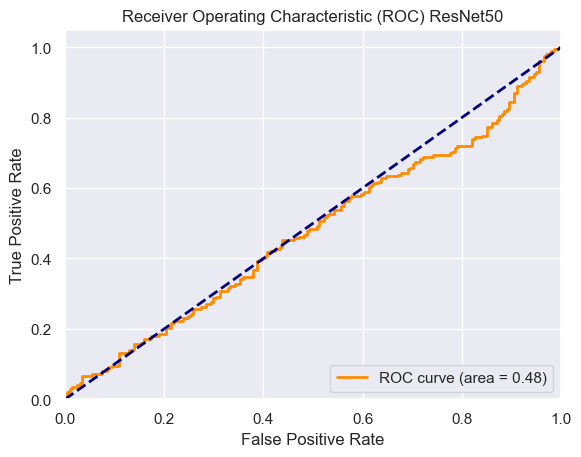

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.77      0.60       201
           1       0.48      0.22      0.30       199

    accuracy                           0.49       400
   macro avg       0.49      0.49      0.45       400
weighted avg       0.49      0.49      0.45       400



In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = resnet50_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ResNet50')
plt.savefig('ResNet50_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ResNet50')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

#### 10% labeled

In [26]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_10_percent, y_train_10_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone.
resnet50_backbone = keras.Model(
    simsiam_resnet50.encoder.input, simsiam_resnet50.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
resnet50_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = resnet50_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
resnet50_linear_model = keras.Model(inputs, outputs, name="resnet50_linear_model")

# Compile model and start training.
resnet50_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
resnet50_history = resnet50_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = resnet50_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
5/5 [==============================] - 85s 18s/step - loss: 1.3538 - accuracy: 0.5000 - val_loss: 2.0565 - val_accuracy: 0.5025
Epoch 2/50
5/5 [==============================] - 74s 17s/step - loss: 1.4257 - accuracy: 0.5437 - val_loss: 1.1646 - val_accuracy: 0.5025
Epoch 3/50
5/5 [==============================] - 70s 17s/step - loss: 1.5813 - accuracy: 0.4750 - val_loss: 1.2643 - val_accuracy: 0.5025
Epoch 4/50
5/5 [==============================] - 75s 18s/step - loss: 3.0068 - accuracy: 0.5125 - val_loss: 0.7083 - val_accuracy: 0.5475
Epoch 5/50
5/5 [==============================] - 71s 17s/step - loss: 4.3512 - accuracy: 0.4875 - val_loss: 2.4577 - val_accuracy: 0.5025
Epoch 6/50
13/13 [==============================] - 48s 4s/step - loss: 2.0565 - accuracy: 0.5025
Test accuracy: 50.25%


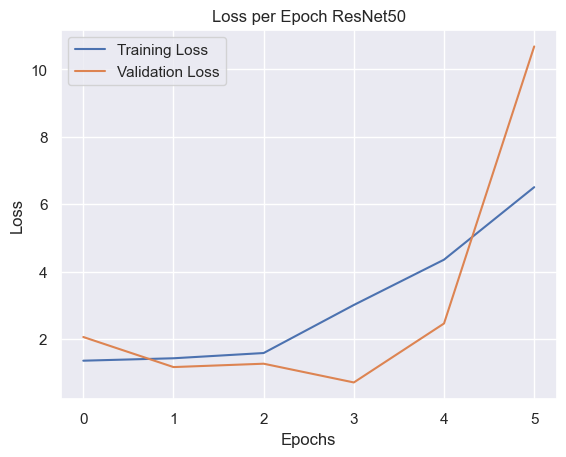

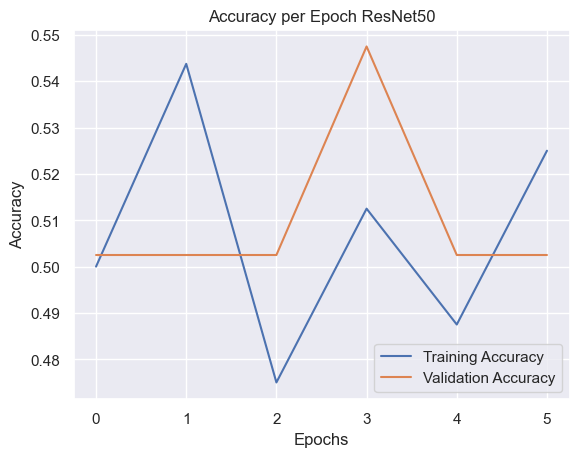

In [27]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(resnet50_history.history['loss'], label='Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch ResNet50')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch ResNet50')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = resnet50_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

13/13 [==============================] - 58s 4s/step
Accuracy: 50.25%
Precision: 0.00
Recall: 0.00
F1-score: 0.00


c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13/13 [==============================] - 57s 4s/step


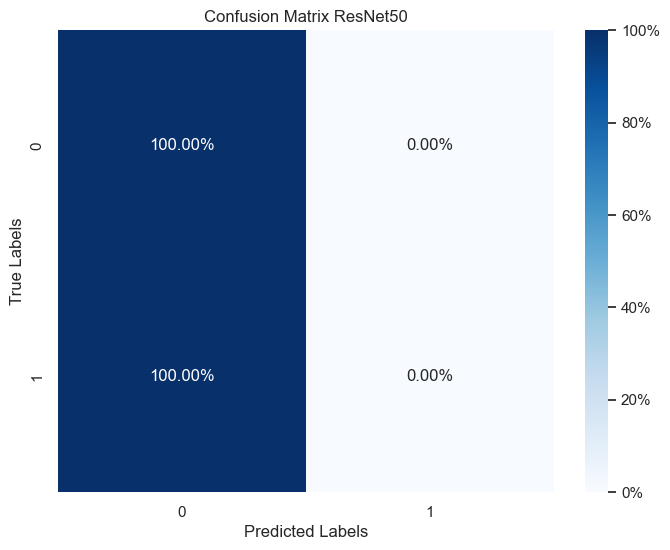

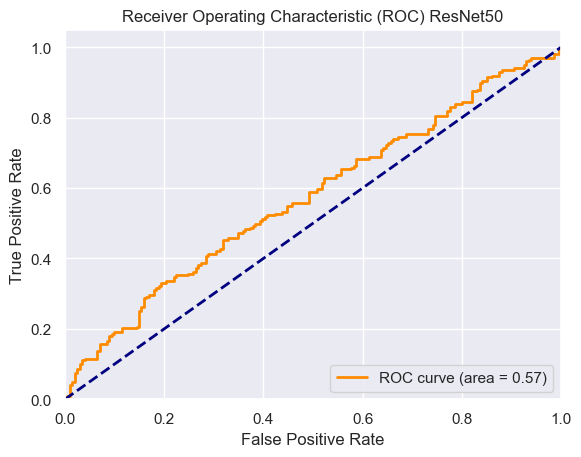

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       201
           1       0.00      0.00      0.00       199

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.34       400



c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = resnet50_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ResNet50')
plt.savefig('ResNet50_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ResNet50')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

#### 20% labeled

In [30]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train_20_percent, y_train_20_percent))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone.
resnet50_backbone = keras.Model(
    simsiam_resnet50.encoder.input, simsiam_resnet50.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
resnet50_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = resnet50_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
resnet50_linear_model = keras.Model(inputs, outputs, name="resnet50_linear_model")

# Compile model and start training.
resnet50_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
resnet50_history = resnet50_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = resnet50_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
10/10 [==============================] - 123s 12s/step - loss: 1.6170 - accuracy: 0.5094 - val_loss: 4.3848 - val_accuracy: 0.4975
Epoch 2/50
10/10 [==============================] - 102s 11s/step - loss: 2.0004 - accuracy: 0.4750 - val_loss: 2.2951 - val_accuracy: 0.4975
Epoch 3/50
10/10 [==============================] - 90s 9s/step - loss: 1.2940 - accuracy: 0.4875 - val_loss: 2.3732 - val_accuracy: 0.4975
Epoch 4/50
10/10 [==============================] - 95s 10s/step - loss: 3.7920 - accuracy: 0.5312 - val_loss: 5.8679 - val_accuracy: 0.4975
Epoch 5/50
10/10 [==============================] - 98s 10s/step - loss: 4.3649 - accuracy: 0.5625 - val_loss: 2.2128 - val_accuracy: 0.5025
Epoch 6/50
10/10 [==============================] - 106s 11s/step - loss: 7.4801 - accuracy: 0.4750 - val_loss: 11.4110 - val_accuracy: 0.4975
Epoch 7/50
10/10 [==============================] - 103s 11s/step - loss: 11.5239 - accuracy: 0.4375 - val_loss: 9.9597 - val_accuracy: 0.5025
Epoch 8/

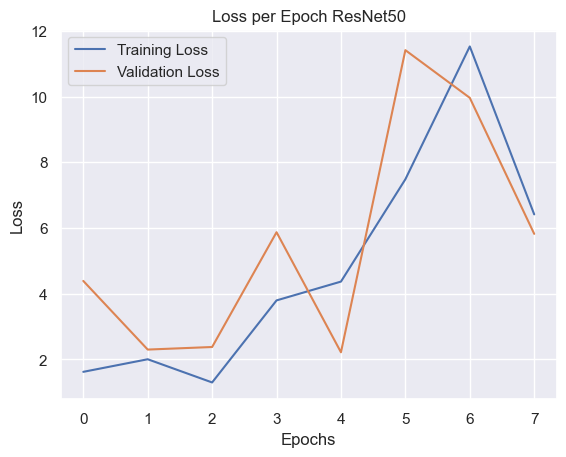

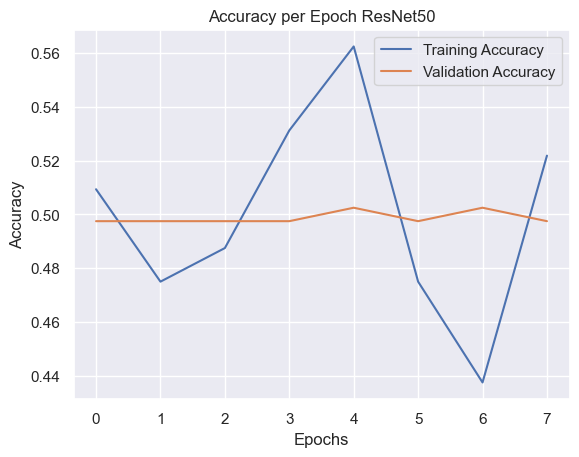

In [31]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(resnet50_history.history['loss'], label='Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch ResNet50')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch ResNet50')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = resnet50_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

13/13 [==============================] - 61s 4s/step
Accuracy: 49.75%
Precision: 0.50
Recall: 1.00
F1-score: 0.66


13/13 [==============================] - 73s 6s/step


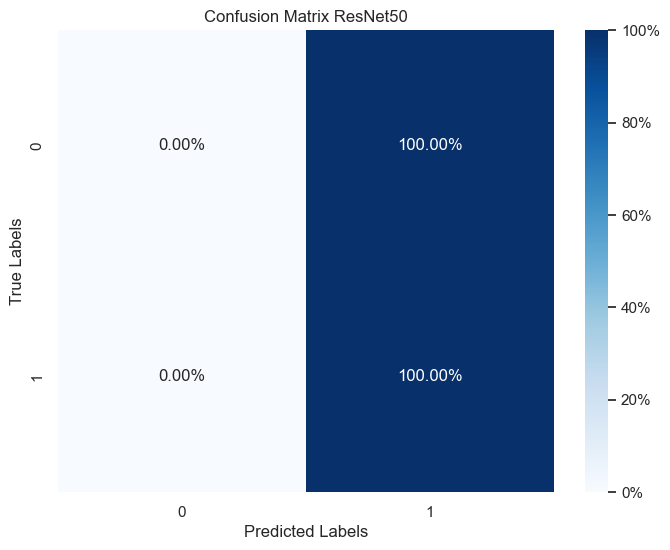

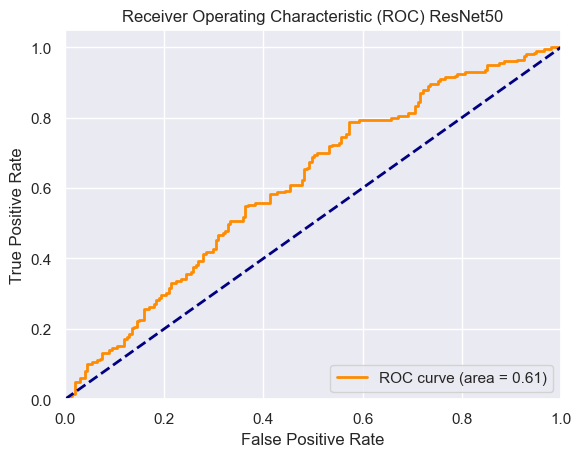

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       201
           1       0.50      1.00      0.66       199

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = resnet50_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ResNet50')
plt.savefig('ResNet50_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ResNet50')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

### ResNet50V2

Epoch 1/50
37/37 [==============================] - 244s 6s/step - loss: -0.5654
Epoch 2/50
37/37 [==============================] - 248s 7s/step - loss: -0.9063
Epoch 3/50
37/37 [==============================] - 248s 7s/step - loss: -0.9373
Epoch 4/50
37/37 [==============================] - 249s 7s/step - loss: -0.9452
Epoch 5/50
37/37 [==============================] - 253s 7s/step - loss: -0.9494
Epoch 6/50
37/37 [==============================] - 247s 7s/step - loss: -0.9525
Epoch 7/50
37/37 [==============================] - 261s 7s/step - loss: -0.9547
Epoch 8/50
37/37 [==============================] - 247s 7s/step - loss: -0.9565
Epoch 9/50
37/37 [==============================] - 247s 7s/step - loss: -0.9578
Epoch 10/50
37/37 [==============================] - 247s 7s/step - loss: -0.9591
Epoch 11/50
37/37 [==============================] - 246s 7s/step - loss: -0.9599
Epoch 12/50
37/37 [==============================] - 246s 7s/step - loss: -0.9609
Epoch 13/50
37/37 [======

<function matplotlib.pyplot.show(close=None, block=None)>

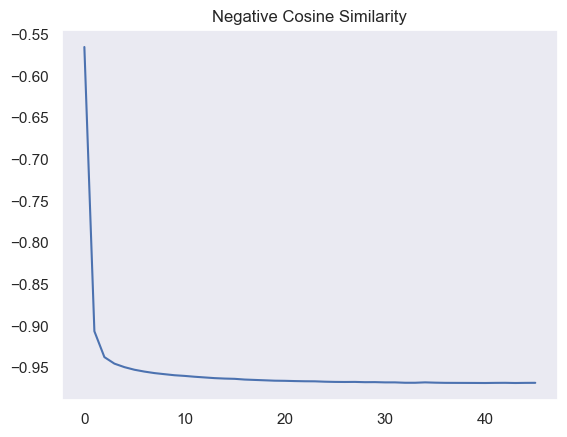

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import ResNet50V2
from keras.applications import ResNet50V2

PROJECT_DIM = 2048  # Projection dimension
LATENT_DIM = 512   # Latent dimension
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
image_size_224 = 224
EPOCHS = 50
BATCH_SIZE = 32

def get_encoder():
    # Load pre-trained VGG16 model without top (fully connected) layers
    base_encoder = ResNet50V2(include_top=False, weights='imagenet', input_shape=(image_size_224, image_size_224, 3))
    for layer in base_encoder.layers:
        layer.trainable = False  # Freeze the layers
    
    # Create a new model with custom top layers
    inputs = tf.keras.Input((image_size_224, image_size_224, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = base_encoder(x, training=False)  # Use base encoder without training
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection head
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))



class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03, decay_steps=steps)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

# Compile model and start training.
simsiam_resnet50v2 = SimSiam(get_encoder(), get_predictor())
simsiam_resnet50v2.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
simsiam_resnet50v2_history = simsiam_resnet50v2.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(simsiam_resnet50v2_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similarity ResNet50V2")
plt.show

In [34]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone VGG19.
resnet50v2_backbone = keras.Model(
    simsiam_resnet50v2.encoder.input, simsiam_resnet50v2.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
resnet50v2_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = resnet50v2_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
resnet50v2_linear_model = keras.Model(inputs, outputs, name="resnet50_linear_model")

# Compile model and start training.
resnet50v2_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
resnet50v2_history = resnet50v2_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = resnet50v2_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
37/37 [==============================] - 143s 4s/step - loss: 2.3242 - accuracy: 0.6053 - val_loss: 2.8355 - val_accuracy: 0.5498
Epoch 2/50
37/37 [==============================] - 152s 4s/step - loss: 2.0503 - accuracy: 0.6586 - val_loss: 3.7130 - val_accuracy: 0.5567
Epoch 3/50
37/37 [==============================] - 153s 4s/step - loss: 1.8445 - accuracy: 0.6896 - val_loss: 0.8885 - val_accuracy: 0.7491
Epoch 4/50
37/37 [==============================] - 151s 4s/step - loss: 2.4603 - accuracy: 0.6612 - val_loss: 6.8376 - val_accuracy: 0.5704
Epoch 5/50
37/37 [==============================] - 151s 4s/step - loss: 2.2400 - accuracy: 0.7154 - val_loss: 1.1603 - val_accuracy: 0.7457
Epoch 6/50
37/37 [==============================] - 151s 4s/step - loss: 1.4173 - accuracy: 0.7291 - val_loss: 1.4110 - val_accuracy: 0.7457
Epoch 7/50
37/37 [==============================] - 152s 4s/step - loss: 2.8247 - accuracy: 0.6905 - val_loss: 2.2837 - val_accuracy: 0.6942
Epoch 8/50
37

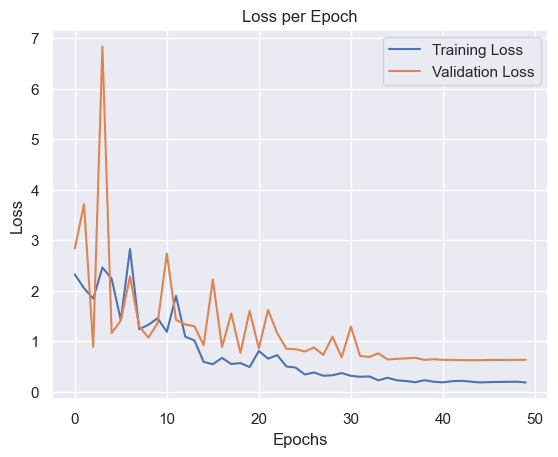

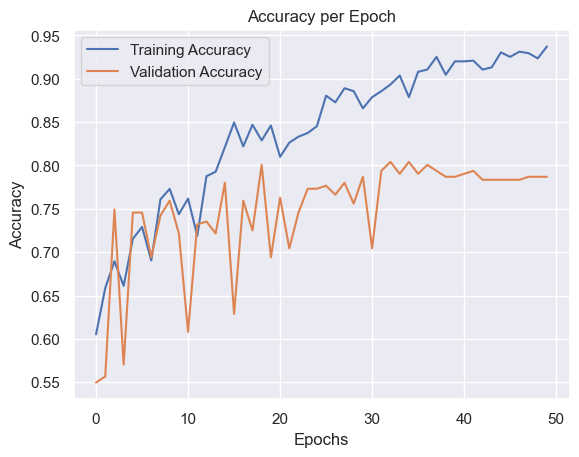

In [35]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(resnet50v2_history.history['loss'], label='Training Loss')
plt.plot(resnet50v2_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch ResNet50V2')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(resnet50v2_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet50v2_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch ResNet50V2')
plt.legend()
plt.show()


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = resnet50v2_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

10/10 [==============================] - 33s 3s/step
Accuracy: 78.69%
Precision: 0.81
Recall: 0.78
F1-score: 0.79


10/10 [==============================] - 31s 3s/step
Confusion Matrix:
[[109  28]
 [ 34 120]]


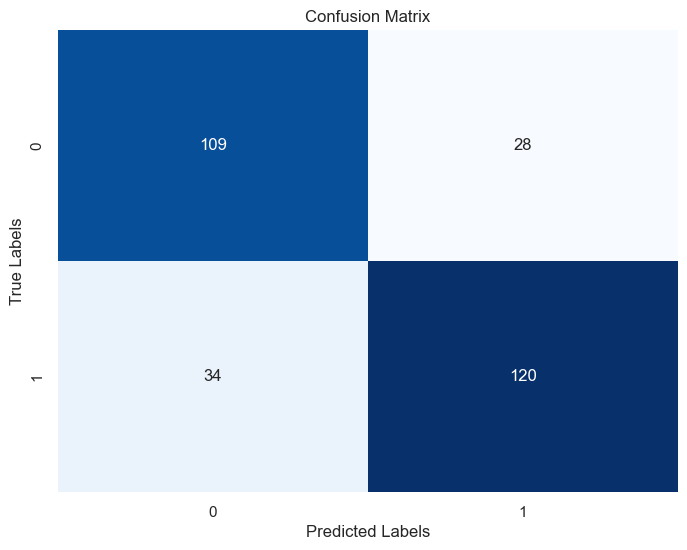

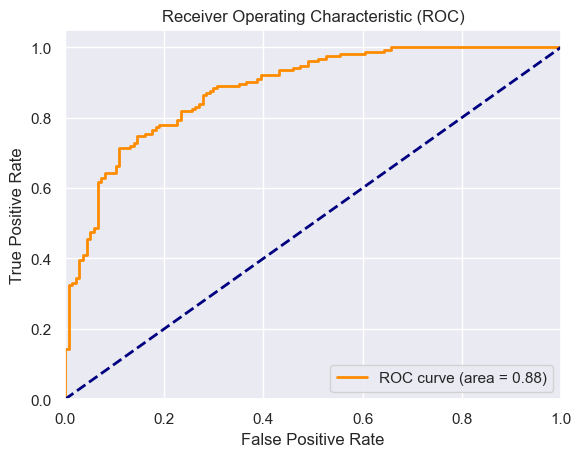

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       137
           1       0.81      0.78      0.79       154

    accuracy                           0.79       291
   macro avg       0.79      0.79      0.79       291
weighted avg       0.79      0.79      0.79       291



In [37]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = resnet50v2_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ResNet50V2')
plt.savefig('ResNet50V2_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ResNet50V2')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

### EfficientNetB0

Epoch 1/50
37/37 [==============================] - 166s 4s/step - loss: -0.6962
Epoch 2/50
37/37 [==============================] - 152s 4s/step - loss: -0.9737
Epoch 3/50
37/37 [==============================] - 158s 4s/step - loss: -0.9809
Epoch 4/50
37/37 [==============================] - 158s 4s/step - loss: -0.9825
Epoch 5/50
37/37 [==============================] - 158s 4s/step - loss: -0.9835
Epoch 6/50
37/37 [==============================] - 168s 5s/step - loss: -0.9839
Epoch 7/50
37/37 [==============================] - 158s 4s/step - loss: -0.9844
Epoch 8/50
37/37 [==============================] - 158s 4s/step - loss: -0.9850
Epoch 9/50
37/37 [==============================] - 158s 4s/step - loss: -0.9854
Epoch 10/50
37/37 [==============================] - 160s 4s/step - loss: -0.9857
Epoch 11/50
37/37 [==============================] - 158s 4s/step - loss: -0.9859
Epoch 12/50
37/37 [==============================] - 158s 4s/step - loss: -0.9855
Epoch 13/50
37/37 [======

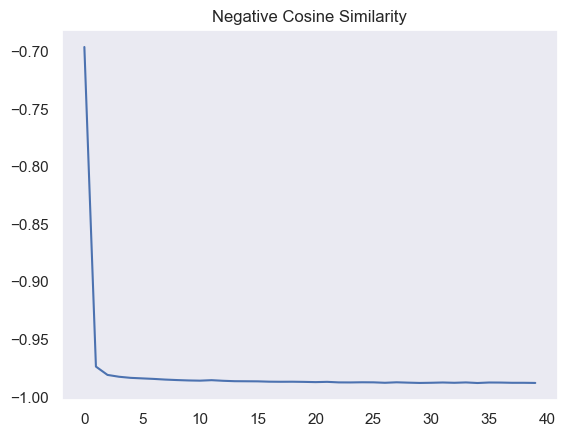

Epoch 1/50
37/37 [==============================] - 125s 3s/step - loss: 0.7193 - accuracy: 0.5219 - val_loss: 0.7513 - val_accuracy: 0.4742
Epoch 2/50
37/37 [==============================] - 103s 3s/step - loss: 0.6756 - accuracy: 0.5770 - val_loss: 0.6532 - val_accuracy: 0.6048
Epoch 3/50
37/37 [==============================] - 105s 3s/step - loss: 0.6654 - accuracy: 0.5976 - val_loss: 0.7326 - val_accuracy: 0.5292
Epoch 4/50
37/37 [==============================] - 104s 3s/step - loss: 0.6602 - accuracy: 0.6088 - val_loss: 0.6148 - val_accuracy: 0.6667
Epoch 5/50
37/37 [==============================] - 104s 3s/step - loss: 0.6213 - accuracy: 0.6432 - val_loss: 0.6245 - val_accuracy: 0.6804
Epoch 6/50
37/37 [==============================] - 104s 3s/step - loss: 0.6007 - accuracy: 0.6715 - val_loss: 0.6996 - val_accuracy: 0.5567
Epoch 7/50
37/37 [==============================] - 104s 3s/step - loss: 0.6244 - accuracy: 0.6432 - val_loss: 0.6992 - val_accuracy: 0.5601
Epoch 8/50
37

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import EfficientNetB0

PROJECT_DIM = 2048  # Projection dimension
LATENT_DIM = 512   # Latent dimension
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
image_size_224 = 224
EPOCHS = 50
BATCH_SIZE = 32

def get_encoder():
    # Load pre-trained EfficientNetB0 model without top (fully connected) layers
    base_encoder = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(image_size_224, image_size_224, 3))
    for layer in base_encoder.layers:
        layer.trainable = False  # Freeze the layers
    
    # Create a new model with custom top layers
    inputs = tf.keras.Input((image_size_224, image_size_224, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = base_encoder(x, training=False)  # Use base encoder without training
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection head
    x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))



class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}



# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03, decay_steps=steps)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

# Compile model and start training.
simsiam_eff = SimSiam(get_encoder(), get_predictor())
simsiam_eff.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
simsiam_eff_history = simsiam_eff.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(simsiam_eff_history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similarity")
plt.show()


# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone EfficientNetB0.
eff_backbone = keras.Model(
    simsiam_eff.encoder.input, simsiam_eff.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
eff_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = eff_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
eff_linear_model = keras.Model(inputs, outputs, name="eff_linear_model")

# Compile model and start training.
eff_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
eff_history = eff_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = eff_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

In [39]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone EfficientNetB0.
eff_backbone = keras.Model(
    simsiam_eff.encoder.input, simsiam_eff.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
eff_backbone.trainable = False
inputs = layers.Input((224, 224, 3))
x = eff_backbone(inputs, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)
eff_linear_model = keras.Model(inputs, outputs, name="eff_linear_model")

# Compile model and start training.
eff_linear_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
eff_history = eff_linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = eff_linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/50
37/37 [==============================] - 112s 3s/step - loss: 0.7110 - accuracy: 0.5254 - val_loss: 0.6732 - val_accuracy: 0.5326
Epoch 2/50
37/37 [==============================] - 89s 2s/step - loss: 0.7158 - accuracy: 0.5271 - val_loss: 0.7229 - val_accuracy: 0.5292
Epoch 3/50
37/37 [==============================] - 89s 2s/step - loss: 0.6419 - accuracy: 0.6131 - val_loss: 0.6565 - val_accuracy: 0.5670
Epoch 4/50
37/37 [==============================] - 88s 2s/step - loss: 0.6311 - accuracy: 0.6268 - val_loss: 0.6699 - val_accuracy: 0.5739
Epoch 5/50
37/37 [==============================] - 94s 3s/step - loss: 0.6408 - accuracy: 0.6242 - val_loss: 0.6565 - val_accuracy: 0.5945
Epoch 6/50
37/37 [==============================] - 101s 3s/step - loss: 0.6051 - accuracy: 0.6819 - val_loss: 0.6146 - val_accuracy: 0.7045
Epoch 7/50
37/37 [==============================] - 100s 3s/step - loss: 0.6157 - accuracy: 0.6561 - val_loss: 0.6091 - val_accuracy: 0.7113
Epoch 8/50
37/37 

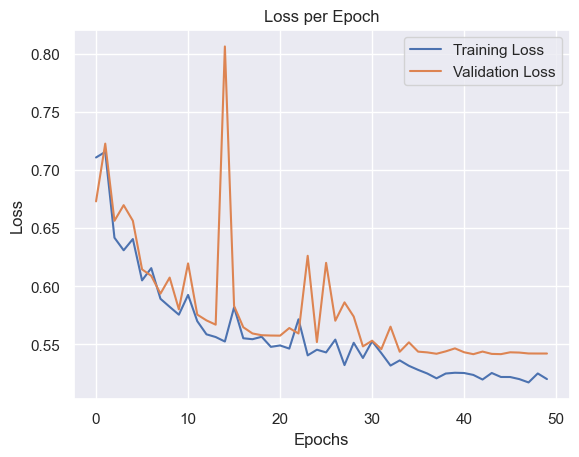

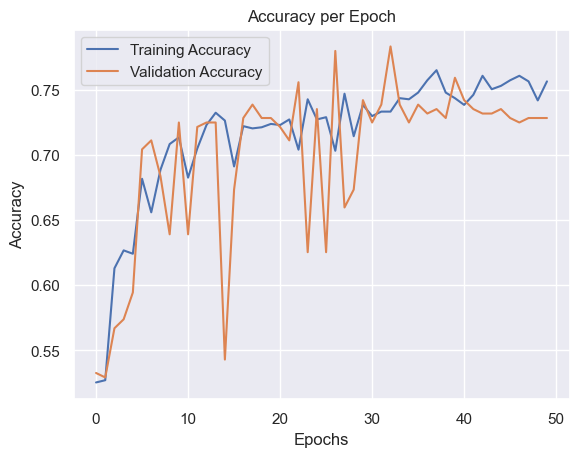

In [40]:
import matplotlib.pyplot as plt

# Plot loss per epoch
plt.plot(eff_history.history['loss'], label='Training Loss')
plt.plot(eff_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch EfficientNet')
plt.legend()
plt.show()

# Plot accuracy per epoch
plt.plot(eff_history.history['accuracy'], label='Training Accuracy')
plt.plot(eff_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch Efficient Net')
plt.legend()
plt.show()


In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_pred = eff_linear_model.predict(test_ds).flatten()

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract ground truth labels from the test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))


10/10 [==============================] - 25s 2s/step
Accuracy: 72.85%
Precision: 0.77
Recall: 0.70
F1-score: 0.73


10/10 [==============================] - 27s 3s/step
Confusion Matrix:
[[104  33]
 [ 46 108]]


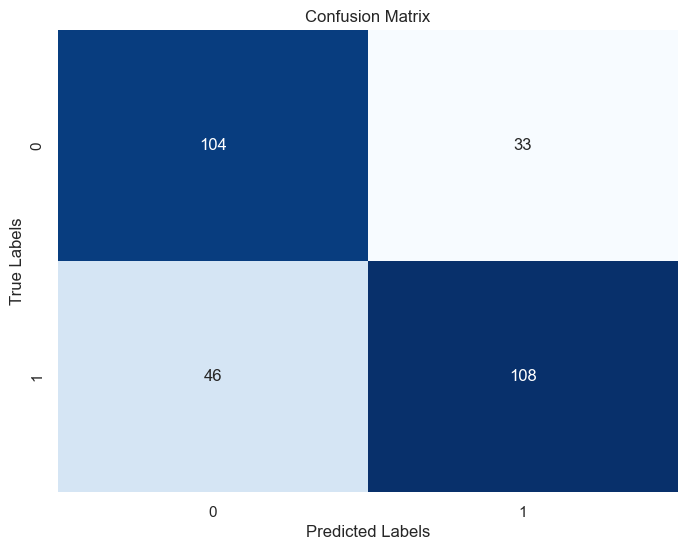

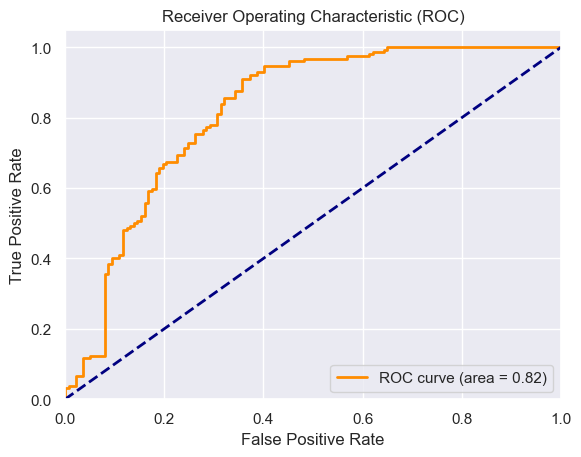

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       137
           1       0.77      0.70      0.73       154

    accuracy                           0.73       291
   macro avg       0.73      0.73      0.73       291
weighted avg       0.73      0.73      0.73       291



In [42]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_proba = eff_linear_model.predict(test_ds)

# Convert probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the test set
y_true = np.concatenate([y for _, y in test_ds])

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute percentages
conf_mat_percentage = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ResNet50V2')
plt.savefig('Eff_conf_matrix_percent.png')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Eff')
plt.legend(loc="lower right")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)
